# Data Analysis (cavity_claw_RouteMeander_eigenmode)

## Configuration

Disable cell scrolling.

Parameters are stored in a shared script.

In [53]:
from parameters import *
os.makedirs('scalers', exist_ok=True)
os.makedirs(f'{DATA_DIR}', exist_ok=True)
os.makedirs(f'{DATA_DIR}/npy', exist_ok=True)

## Library

In [2]:
import json
import numpy as np
import pandas as pd
from pandas import json_normalize
from sklearn.preprocessing import MinMaxScaler
import joblib

## Datasets

### Load

In [4]:
import pandas as pd

df = pd.read_json("hf://datasets/SQuADDS/SQuADDS_DB/cavity_claw-RouteMeander-eigenmode.json")

### Look at the data and structure

In [5]:
#look at the first value
first_entry = df.iloc[100]

# Print the headers and their corresponding values
for header, value in first_entry.items():
    print(f"{header}: {value}")

sim_options: {'setup': {'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'min_freq_ghz': 1, 'n_modes': 1, 'max_delta_f': 0.05, 'max_passes': 50, 'min_passes': 1, 'min_converged': 1, 'pct_refinement': 30, 'basis_order': 1, 'vars': {'Lj': '0nH', 'Cj': '0fF'}, 'min_converged_passes': 2}, 'simulator': 'Ansys HFSS'}
sim_results: {'cavity_frequency': 5987186143.809999, 'kappa': 22053.7288176, 'units': 'Hz'}
design: {'design_options': {'claw_opts': {'connection_pads': {'readout': {'connector_location': '90', 'connector_type': '0', 'claw_length': '440um', 'ground_spacing': '4.1um', 'claw_gap': '5.1um', 'claw_width': '15um', 'claw_cpw_width': '11.7um', 'claw_cpw_length': '0um'}}, 'orientation': '-90', 'pos_x': '-1500um', 'cross_length': '0um', 'cross_width': '0um', 'cross_gap': '0um'}, 'cpw_opts': {'fillet': '49.9um', 'total_length': '3900um', 'trace_width': '11.7um', 'trace_gap': '5.1um', 'lead': {'start_straight': '50um'}, 'pin_inputs': {'start_pin': {'component': 'cplr', 

In [6]:
#Look at the headers relevant for us, to start lets only look at the sim_results (our x data) and design (our y data)
sim_results_column = df['sim_results']
print(sim_results_column, '\n\n')

design_column = df['design']
print(design_column)

0       {'cavity_frequency': 5353549772.64, 'kappa': 1...
1       {'cavity_frequency': 8399240836.29, 'kappa': 2...
2       {'cavity_frequency': 8694844797.89, 'kappa': 2...
3       {'cavity_frequency': 6616574393.559999, 'kappa...
4       {'cavity_frequency': 7986835171.7, 'kappa': 20...
                              ...                        
1211    {'cavity_frequency': 7489688801.09, 'kappa': 4...
1212    {'cavity_frequency': 7452442461.75, 'kappa': 3...
1213    {'cavity_frequency': 7415826341.76, 'kappa': 4...
1214    {'cavity_frequency': 7378752058.07, 'kappa': 4...
1215    {'cavity_frequency': 7342036181.17, 'kappa': 5...
Name: sim_results, Length: 1216, dtype: object 


0       {'design_options': {'claw_opts': {'connection_...
1       {'design_options': {'claw_opts': {'connection_...
2       {'design_options': {'claw_opts': {'connection_...
3       {'design_options': {'claw_opts': {'connection_...
4       {'design_options': {'claw_opts': {'connection_...
                      

In [7]:
#take a look at everything in the design dataset
# Flatten the design column
design_flat = json_normalize(df['design'])

# List all column headers
design_column_vals = design_flat.columns.tolist()
print(design_column_vals)
print('length: ',len(design_column_vals))

['coupler_type', 'resonator_type', 'design_tool', 'design_options.claw_opts.connection_pads.readout.connector_location', 'design_options.claw_opts.connection_pads.readout.connector_type', 'design_options.claw_opts.connection_pads.readout.claw_length', 'design_options.claw_opts.connection_pads.readout.ground_spacing', 'design_options.claw_opts.connection_pads.readout.claw_gap', 'design_options.claw_opts.connection_pads.readout.claw_width', 'design_options.claw_opts.connection_pads.readout.claw_cpw_width', 'design_options.claw_opts.connection_pads.readout.claw_cpw_length', 'design_options.claw_opts.orientation', 'design_options.claw_opts.pos_x', 'design_options.claw_opts.cross_length', 'design_options.claw_opts.cross_width', 'design_options.claw_opts.cross_gap', 'design_options.cpw_opts.fillet', 'design_options.cpw_opts.total_length', 'design_options.cpw_opts.trace_width', 'design_options.cpw_opts.trace_gap', 'design_options.cpw_opts.lead.start_straight', 'design_options.cpw_opts.pin_inp

### Reformat

In [8]:
#flatten what will be our X data
X = json_normalize(df['sim_results'])
# Dropping the 'units' column for now because i think they are al in Hz and this info isnt useful
X = X.drop(columns=['units'])
print(X)

      cavity_frequency          kappa
0         5.353550e+09  161106.598429
1         8.399241e+09  268412.116632
2         8.694845e+09  255873.654612
3         6.616574e+09   30459.761161
4         7.986835e+09  208304.221064
...                ...            ...
1211      7.489689e+09   46004.713078
1212      7.452442e+09   38837.211205
1213      7.415826e+09   46696.417529
1214      7.378752e+09   41526.048615
1215      7.342036e+09   58463.648381

[1216 rows x 2 columns]


In [9]:
#flatten what will be our y data
y = json_normalize(df['design'])

#get rid of this column because there are two spellings in the dataset that will confuse the NN. We always just use Qiskit, so for now we dont need this
y = y.drop(columns=['design_tool']) 

#output of processing later on when I dont drop this column:
'''
One-hot encoding for 'design_tool':
      design_tool_Qiskit Metal  design_tool_qiskit-metal
 0                          0.0                       1.0 
'''

print(y)

     coupler_type resonator_type  \
0             CLT        quarter   
1             CLT        quarter   
2             CLT        quarter   
3             CLT        quarter   
4             CLT        quarter   
...           ...            ...   
1211          CLT        quarter   
1212          CLT        quarter   
1213          CLT        quarter   
1214          CLT        quarter   
1215          CLT        quarter   

     design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                    90                    
1                                                    90                    
2                                                    90                    
3                                                    90                    
4                                                    90                    
...                                                 ...                    
1211                               

### Validate and View Data

In [10]:
display(X)

cavity_frequency          kappa
0         5.353550e+09  161106.598429
1         8.399241e+09  268412.116632
2         8.694845e+09  255873.654612
3         6.616574e+09   30459.761161
4         7.986835e+09  208304.221064
...                ...            ...
1211      7.489689e+09   46004.713078
1212      7.452442e+09   38837.211205
1213      7.415826e+09   46696.417529
1214      7.378752e+09   41526.048615
1215      7.342036e+09   58463.648381

[1216 rows x 2 columns]

In [11]:
display(y)

coupler_type resonator_type  \
0             CLT        quarter   
1             CLT        quarter   
2             CLT        quarter   
3             CLT        quarter   
4             CLT        quarter   
...           ...            ...   
1211          CLT        quarter   
1212          CLT        quarter   
1213          CLT        quarter   
1214          CLT        quarter   
1215          CLT        quarter   

     design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                    90                    
1                                                    90                    
2                                                    90                    
3                                                    90                    
4                                                    90                    
...                                                 ...                    
1211                                                 90                    
1212                                                 90                    
1213                                                 90                    
1214                                                 90                    
1215                                                 90                    

     design_options.claw_opts.connection_pads.readout.connector_type  \
0                                                     0                
1                                                     0                
2                                                     0                
3                                                     0                
4                                                     0                
...                                                 ...                
1211                                                  0                
1212                                                  0                
1213                                                  0                
1214                                                  0                
1215                                                  0                

     design_options.claw_opts.connection_pads.readout.claw_length  \
0                                                 220um             
1                                                 270um             
2                                                 210um             
3                                                 210um             
4                                                 360um             
...                                                 ...             
1211                                              380um             
1212                                              390um             
1213                                              400um             
1214                                              410um             
1215                                              420um             

     design_options.claw_opts.connection_pads.readout.ground_spacing  \
0                                                 4.1um                
1                                                 4.1um                
2                                                 4.1um                
3                                                 4.1um                
4                                                 4.1um                
...                                                 ...                
1211                                               10um                
1212                                               10um                
1213                                               10um                
1214                                               10um                
1215                                               10um                

     design_options.claw_opts.connection_pads.readout.claw_gap  \
0                                 

## Transform Y to Numerical Values

We need to do this because the MLP needs its output to have numerical values, so we will transform the 44 columns into numerical equivallents

In [12]:
#look at the format all of the y values are in
for col in y.columns:
    print(f"{col}  {y[col].iloc[0]}")
print(y.shape)

coupler_type  CLT
resonator_type  quarter
design_options.claw_opts.connection_pads.readout.connector_location  90
design_options.claw_opts.connection_pads.readout.connector_type  0
design_options.claw_opts.connection_pads.readout.claw_length  220um
design_options.claw_opts.connection_pads.readout.ground_spacing  4.1um
design_options.claw_opts.connection_pads.readout.claw_gap  5.1um
design_options.claw_opts.connection_pads.readout.claw_width  15um
design_options.claw_opts.connection_pads.readout.claw_cpw_width  11.7um
design_options.claw_opts.connection_pads.readout.claw_cpw_length  0um
design_options.claw_opts.orientation  -90
design_options.claw_opts.pos_x  -1500um
design_options.claw_opts.cross_length  0um
design_options.claw_opts.cross_width  0um
design_options.claw_opts.cross_gap  0um
design_options.cpw_opts.fillet  49.9um
design_options.cpw_opts.total_length  4700um
design_options.cpw_opts.trace_width  11.7um
design_options.cpw_opts.trace_gap  5.1um
design_options.cpw_opts.lead.st

In [13]:
categorical_cols = ['coupler_type', 'resonator_type', 
                        'design_options.cpw_opts.pin_inputs.start_pin.component',
                        'design_options.cpw_opts.pin_inputs.start_pin.pin',
                        'design_options.cpw_opts.pin_inputs.end_pin.component',
                        'design_options.cpw_opts.pin_inputs.end_pin.pin'] #'design_tool', 

if 'One Hot' in ENCODING_TYPE:   # 1. Handle categorical features using one-hot encoding
    #take the above categories, and make 1 for true and 0 for false. if there is more than one value per column, make seperate columns
    #for example, resonator_type can be half or quarter, so make columns for each. each dataset should only havve 1 in either half or quarter column
    y_numerical = pd.get_dummies(y, columns=categorical_cols, dtype=float)
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[onehot_cols])
        print("---")

elif 'Linear' in ENCODING_TYPE:   # 2. Handle categorical features using Linear encoding
    from sklearn.preprocessing import LabelEncoder
    # Linear encoding (label encoding) assigns a unique integer to each category.  
    # It's suitable only for ordinal data (categories with a clear order) but is less interpretable 
    # and can introduce bias if used with nominal data.  Example: Size (small, medium, large) becomes 0, 1, 2.
    # Choose one-hot for nominal data and linear encoding only if your categories have a meaningful order.
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical.columns if col in c]
        print(y_numerical[lin_cols])
        print("---")

elif 'Try Both' in ENCODING_TYPE:
    from sklearn.preprocessing import LabelEncoder

    # 1. one hot
    y_numerical_one_hot = pd.get_dummies(y, columns=categorical_cols, dtype=float)

    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"One-hot encoding for '{col}':")
        onehot_cols = [c for c in y_numerical_one_hot.columns if col in c]
        print(y_numerical_one_hot[onehot_cols])
        print("---")
    
    # 2. linear
    label_encoders = {}
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
    
    y_numerical_linear = y.copy()
    # Apply Label Encoding
    for col in categorical_cols:
        y_numerical_linear[col] = label_encoders[col].fit_transform(y[col])
    
    #take a look at the new columns for the categories:
    for col in categorical_cols:
        print(f"Linear encoding for '{col}':")
        lin_cols = [c for c in y_numerical_linear.columns if col in c]
        print(y_numerical_linear[lin_cols])
        print("---")
    
else:
    print(f'Incorrect value passed to ENCODING_TYPE, passed \'{ENCODING_TYPE}\', please change to \'One Hot\' or \'Linear\' or \'Try Both\'')

One-hot encoding for 'coupler_type':
      coupler_type_CLT  coupler_type_NCap
0                  1.0                0.0
1                  1.0                0.0
2                  1.0                0.0
3                  1.0                0.0
4                  1.0                0.0
...                ...                ...
1211               1.0                0.0
1212               1.0                0.0
1213               1.0                0.0
1214               1.0                0.0
1215               1.0                0.0

[1216 rows x 2 columns]
---
One-hot encoding for 'resonator_type':
      resonator_type_half  resonator_type_quarter
0                     0.0                     1.0
1                     0.0                     1.0
2                     0.0                     1.0
3                     0.0                     1.0
4                     0.0                     1.0
...                   ...                     ...
1211                  0.0                

In [14]:
if 'One Hot' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 45
    print(y_numerical.shape)
elif 'Linear' in ENCODING_TYPE:
    print(y_numerical.shape)
elif 'Try Both' in ENCODING_TYPE:
    #we have added two columns now, so our new shape should be 45
    print('One Hot:', y_numerical_one_hot.shape)
    #we havent added new columns now, so our new shape should be 43
    print('Linear:', y_numerical_linear.shape)

One Hot: (1216, 45)
Linear: (1216, 43)


In [15]:
if 'One Hot' in ENCODING_TYPE:
    y_encoding_formats = [y_numerical]
    y_encoding_format_names = ['one_hot']
elif 'Linear' in ENCODING_TYPE:
    y_encoding_format_names = ['linear']
    y_encoding_formats = [y_numerical]
elif 'Try Both' in ENCODING_TYPE:
    y_encoding_format_names = ['one_hot','linear']
    y_encoding_formats = [y_numerical_one_hot, y_numerical_linear]

y_numerical_removed_um_encoding_formats = []
for y_format in y_encoding_formats:
    y_numerical_removed_um = y_format.copy()
    
    # Extract numerical values and convert units (assuming 'um' for all)
    um_cols = [col for col in y_numerical_removed_um.columns if y_numerical_removed_um[col].astype(str).str.contains('um').any()]
    
    for col in um_cols:
        y_numerical_removed_um[col] = pd.to_numeric(y_numerical_removed_um[col].astype(str).str.replace('um', '', regex=False), errors='coerce') * 1e-6
        y_numerical_removed_um[col] = y_numerical_removed_um[col].round(15) #round to get rid of the long .999999999s that python does sometimes
        
    # Handle boolean categories
    bool_cols = ['design_options.cplr_opts.open_termination']
    for col in bool_cols:
        y_numerical_removed_um[col] = y_numerical_removed_um[col].fillna(0).astype(int) #impute with 0 (False) - adjust as needed
    
    y_numerical_removed_um_encoding_formats.append(y_numerical_removed_um)
    i =0
    for col in y_numerical_removed_um.columns:
        i+=1
        try:
            print(f"{col}-----------Numerical Version:{y_numerical_removed_um[col].iloc[0]}-----------Original:{y[col].iloc[0]}")
        except KeyError:
            print("hot encoding changed this column name from the original")
    print('\n')

design_options.claw_opts.connection_pads.readout.connector_location-----------Numerical Version:90-----------Original:90
design_options.claw_opts.connection_pads.readout.connector_type-----------Numerical Version:0-----------Original:0
design_options.claw_opts.connection_pads.readout.claw_length-----------Numerical Version:0.00022-----------Original:220um
design_options.claw_opts.connection_pads.readout.ground_spacing-----------Numerical Version:4.1e-06-----------Original:4.1um
design_options.claw_opts.connection_pads.readout.claw_gap-----------Numerical Version:5.1e-06-----------Original:5.1um
design_options.claw_opts.connection_pads.readout.claw_width-----------Numerical Version:1.5e-05-----------Original:15um
design_options.claw_opts.connection_pads.readout.claw_cpw_width-----------Numerical Version:1.17e-05-----------Original:11.7um
design_options.claw_opts.connection_pads.readout.claw_cpw_length-----------Numerical Version:0.0-----------Original:0um
design_options.claw_opts.orient

In [16]:
y_numerical_flagged_nan_encoding_formats = []
for y_encoding_formats_um_removed in y_numerical_removed_um_encoding_formats:
    y_numerical_flagged_nan = y_encoding_formats_um_removed.copy()
    y_numerical_flagged_nan.fillna(float(1), inplace=True)
    
    y_numerical_flagged_nan_encoding_formats.append(y_numerical_flagged_nan) #save updated dictionaries to a new list
    
    print('\n')
    print('Now all of these should be numerical')
    for col in y_numerical_flagged_nan.columns:
        print(f"{col}-----------{y_numerical_flagged_nan[col].iloc[0]}")
        #print(f"{col}-----------Numerical Version:{y_numerical_flagged_nan[col].iloc[0]}-----------Original:{y[col].iloc[0]}")



Now all of these should be numerical
design_options.claw_opts.connection_pads.readout.connector_location-----------90
design_options.claw_opts.connection_pads.readout.connector_type-----------0
design_options.claw_opts.connection_pads.readout.claw_length-----------0.00022
design_options.claw_opts.connection_pads.readout.ground_spacing-----------4.1e-06
design_options.claw_opts.connection_pads.readout.claw_gap-----------5.1e-06
design_options.claw_opts.connection_pads.readout.claw_width-----------1.5e-05
design_options.claw_opts.connection_pads.readout.claw_cpw_width-----------1.17e-05
design_options.claw_opts.connection_pads.readout.claw_cpw_length-----------0.0
design_options.claw_opts.orientation------------90
design_options.claw_opts.pos_x------------0.0015
design_options.claw_opts.cross_length-----------0.0
design_options.claw_opts.cross_width-----------0.0
design_options.claw_opts.cross_gap-----------0.0
design_options.cpw_opts.fillet-----------4.99e-05
design_options.cpw_opts.t

In [17]:
y_numerical_floats_encoding_formats = []
for y_numerical_flagged_nan_format in y_numerical_flagged_nan_encoding_formats:
    
    y_numerical_ = y_numerical_flagged_nan_format.copy()
    
    #finger count has a string sometimes even thoguh it is a number, just convert everything to a float to make sure
    y_numerical_['design_options.cplr_opts.finger_count'] = pd.to_numeric(y_numerical_['design_options.cplr_opts.finger_count'])

    y_numerical_floats_encoding_formats.append(y_numerical_)

In [18]:
y_encoding_formats = []
for y_transformed in y_numerical_floats_encoding_formats:
    y_encoding_formats.append(y_transformed)

i=0
for y_encoding_format in y_encoding_formats:
    print('Encoding Type: ',y_encoding_format_names[i])
    display(y_encoding_format)
    i+=1

Encoding Type:  one_hot


design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                    90                    
1                                                    90                    
2                                                    90                    
3                                                    90                    
4                                                    90                    
...                                                 ...                    
1211                                                 90                    
1212                                                 90                    
1213                                                 90                    
1214                                                 90                    
1215                                                 90                    

     design_options.claw_opts.connection_pads.readout.connector_type  \
0                                                     0                
1                                                     0                
2                                                     0                
3                                                     0                
4                                                     0                
...                                                 ...                
1211                                                  0                
1212                                                  0                
1213                                                  0                
1214                                                  0                
1215                                                  0                

      design_options.claw_opts.connection_pads.readout.claw_length  \
0                                               0.00022              
1                                               0.00027              
2                                               0.00021              
3                                               0.00021              
4                                               0.00036              
...                                                 ...              
1211                                            0.00038              
1212                                            0.00039              
1213                                            0.00040              
1214                                            0.00041              
1215                                            0.00042              

      design_options.claw_opts.connection_pads.readout.ground_spacing  \
0                                              0.000004                 
1                                              0.000004                 
2                                              0.000004                 
3                                              0.000004                 
4                                              0.000004                 
...                                                 ...                 
1211                                           0.000010                 
1212                                           0.000010                 
1213                                           0.000010                 
1214                                           0.000010                 
1215                                           0.000010                 

      design_options.claw_opts.connection_pads.readout.claw_gap  \
0                                              0.000005           
1                                              0.000005           
2                                              0.000005           
3                                              0.000005           
4                                              0.000005           
...                                                 ...           
1211                                    

Encoding Type:  linear


coupler_type  resonator_type  \
0                0               1   
1                0               1   
2                0               1   
3                0               1   
4                0               1   
...            ...             ...   
1211             0               1   
1212             0               1   
1213             0               1   
1214             0               1   
1215             0               1   

     design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                    90                    
1                                                    90                    
2                                                    90                    
3                                                    90                    
4                                                    90                    
...                                                 ...                    
1211                                                 90                    
1212                                                 90                    
1213                                                 90                    
1214                                                 90                    
1215                                                 90                    

     design_options.claw_opts.connection_pads.readout.connector_type  \
0                                                     0                
1                                                     0                
2                                                     0                
3                                                     0                
4                                                     0                
...                                                 ...                
1211                                                  0                
1212                                                  0                
1213                                                  0                
1214                                                  0                
1215                                                  0                

      design_options.claw_opts.connection_pads.readout.claw_length  \
0                                               0.00022              
1                                               0.00027              
2                                               0.00021              
3                                               0.00021              
4                                               0.00036              
...                                                 ...              
1211                                            0.00038              
1212                                            0.00039              
1213                                            0.00040              
1214                                            0.00041              
1215                                            0.00042              

      design_options.claw_opts.connection_pads.readout.ground_spacing  \
0                                              0.000004                 
1                                              0.000004                 
2                                              0.000004                 
3                                              0.000004                 
4                                              0.000004                 
...                                                 ...                 
1211                                           0.000010                 
1212                                           0.000010                 
1213                                           0.000010                 
1214                                           0.000010                 
1215                                           0.000010                 

      design_options.claw_opts.connection_pads.readou

### Save the header names of the y data

In [19]:
i=0
for y_encoding_format in y_encoding_formats:
    filename = f'y_characteristics_{y_encoding_format_names[i]}_encoding.csv'
    headers = list(y_encoding_format.columns) 
    
    with open(filename, 'w') as f:
        f.write(','.join(headers))
    i+=1

## Visualize

### X Data

In [20]:
%matplotlib ipympl
#%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

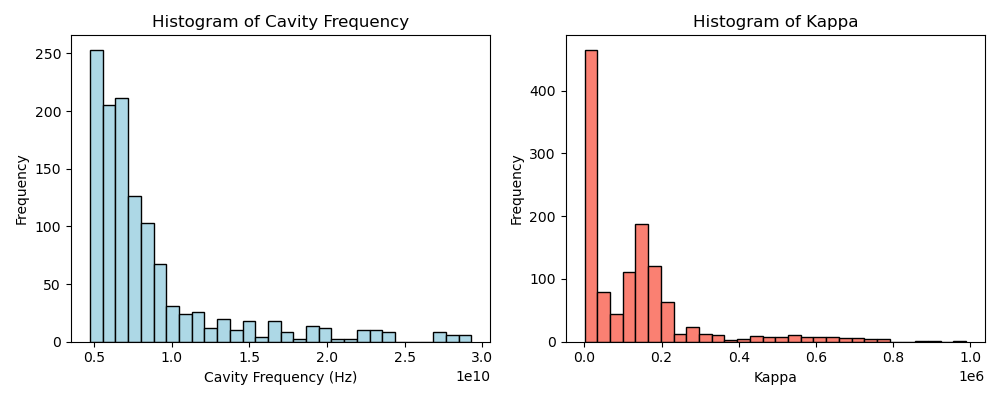

In [21]:
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
#plt.show()

In [22]:
plt.savefig('plots/unscaled_X_data.png')
plt.close()

Text(0, 0.5, 'Kappa')

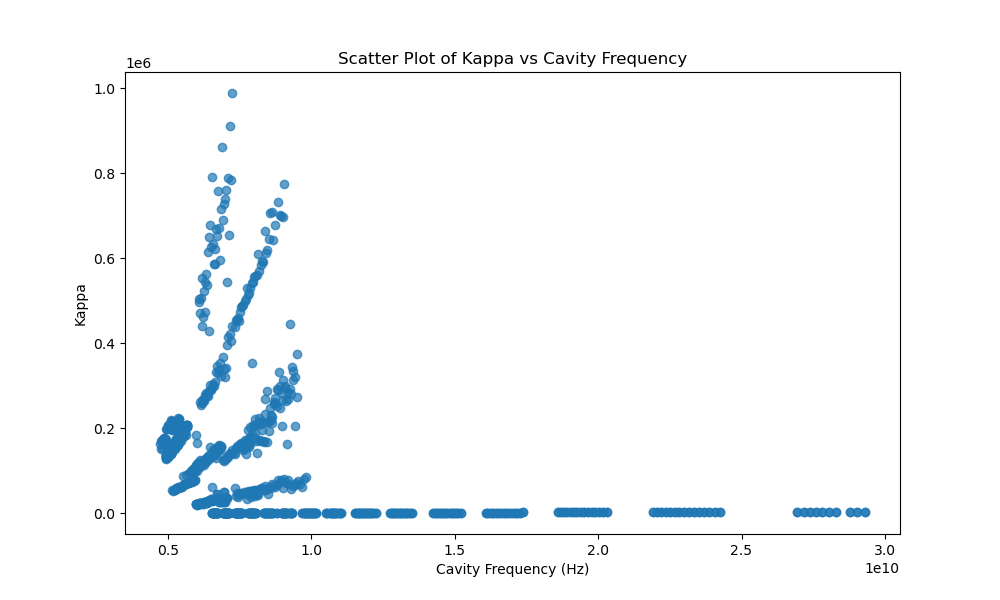

In [23]:
kappa_values = X['kappa']
cavity_frequency_values = X['cavity_frequency']

plt.figure(figsize=(10, 6))
plt.scatter(cavity_frequency_values, kappa_values, alpha=0.7)
plt.title('Scatter Plot of Kappa vs Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Kappa')
#plt.grid(True)
#plt.show()

### Y data

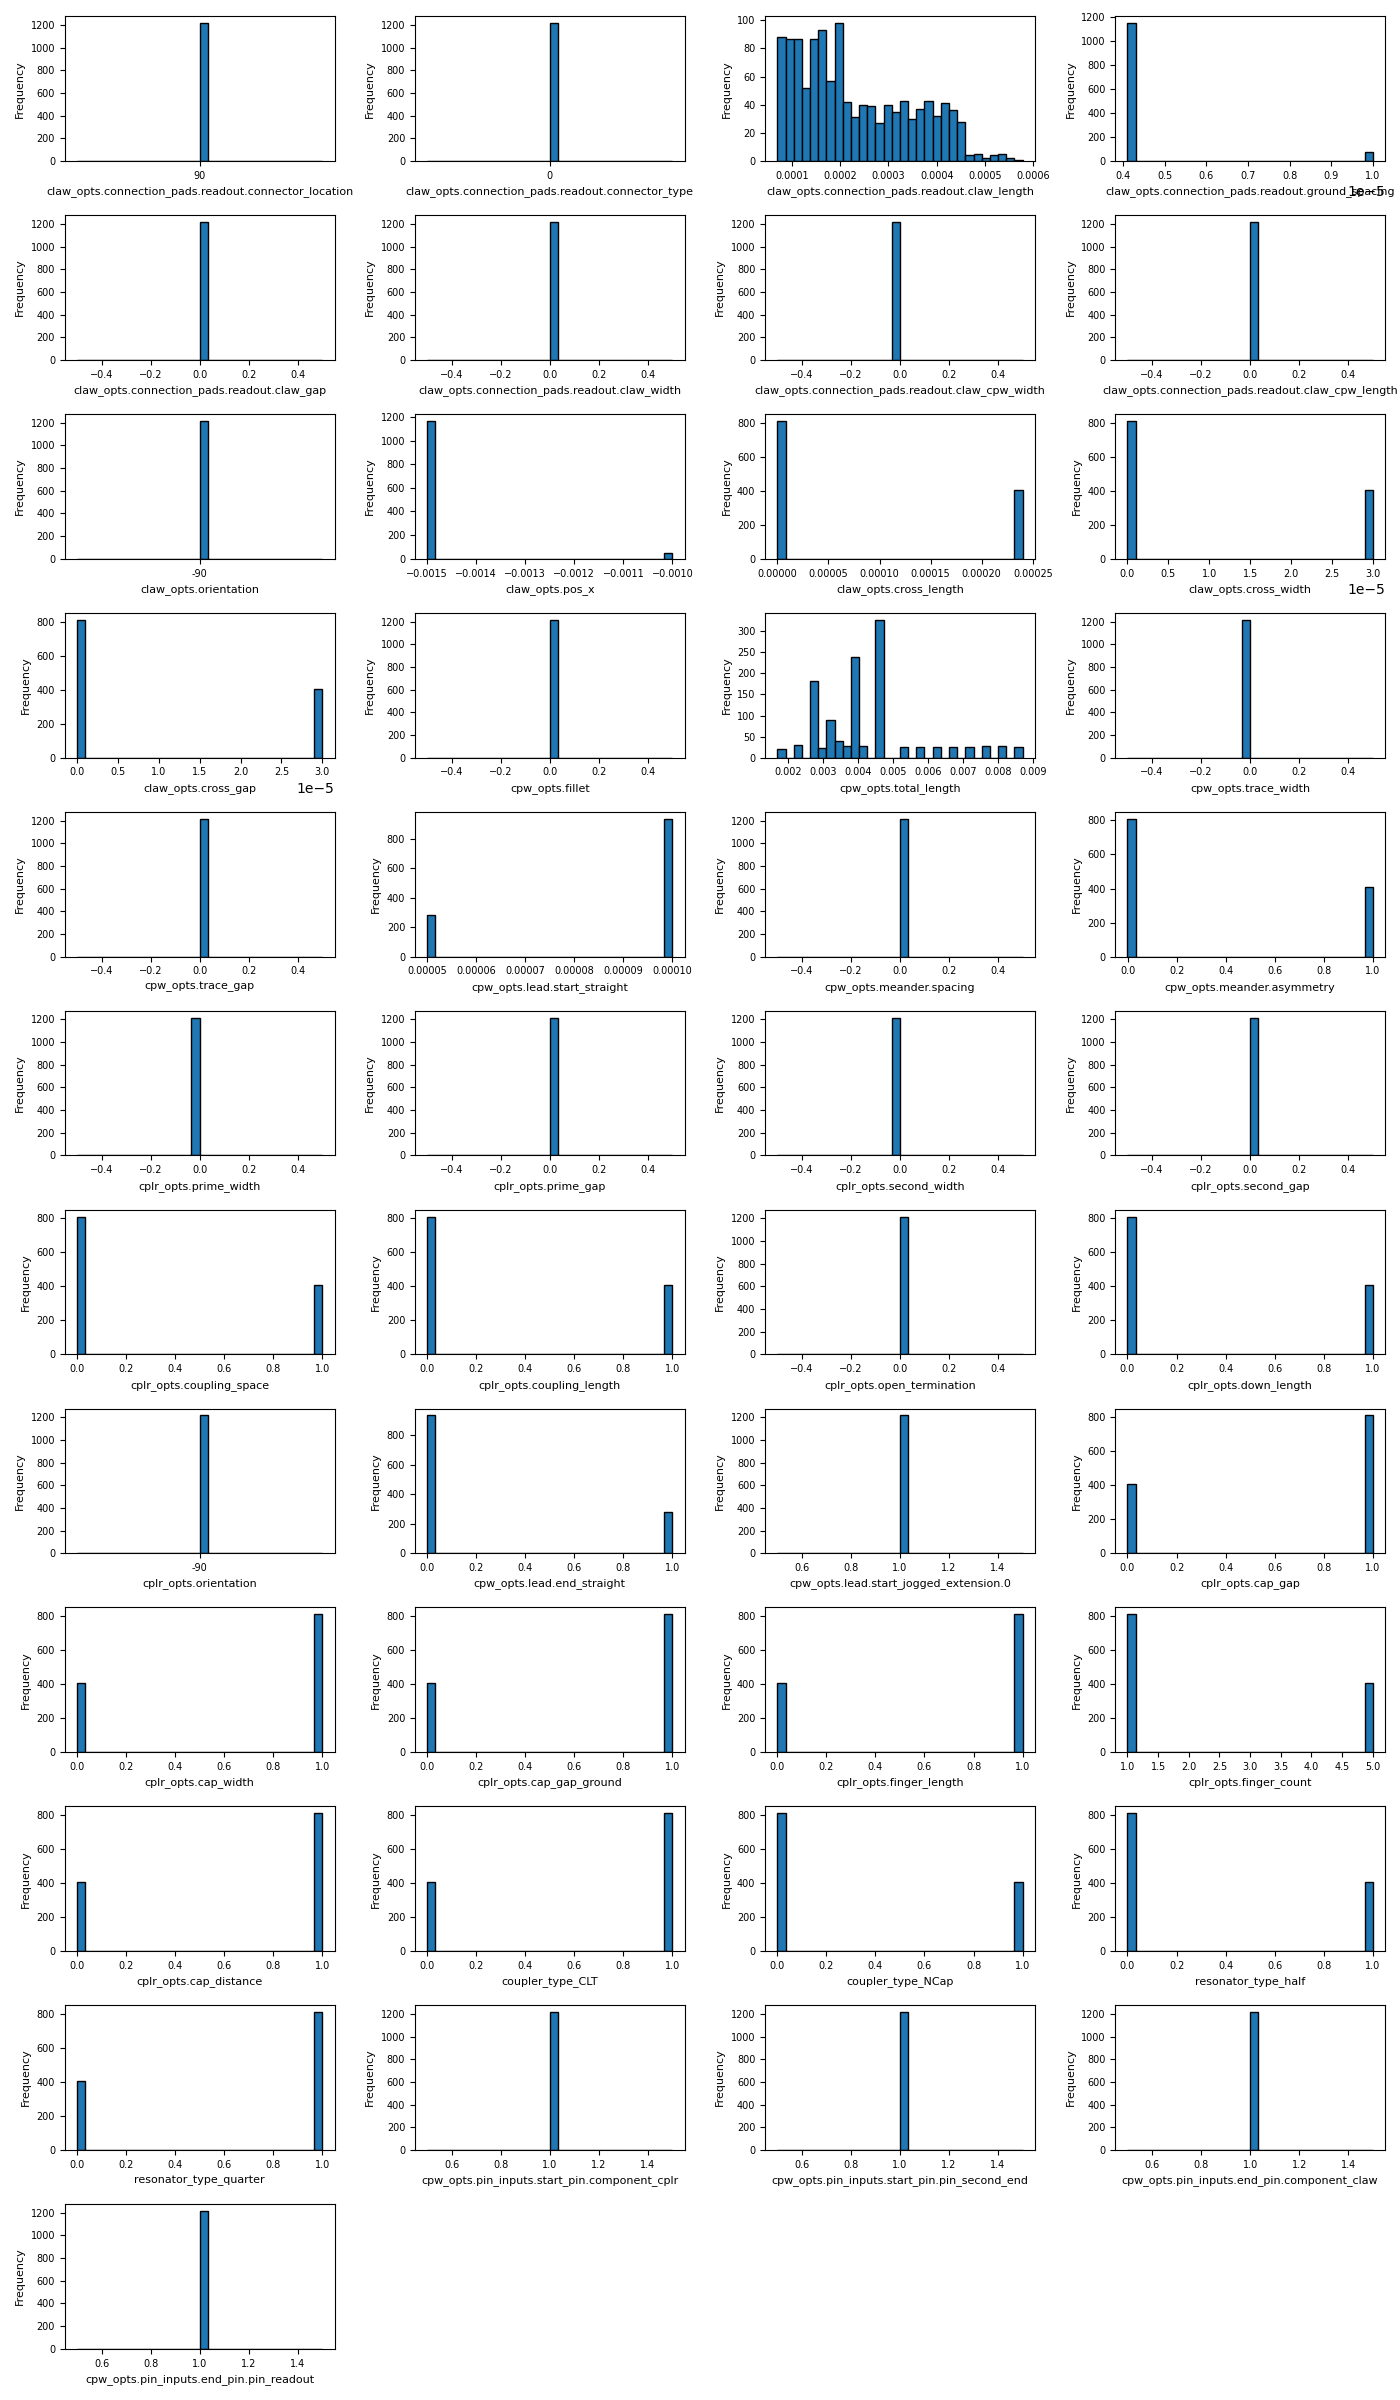

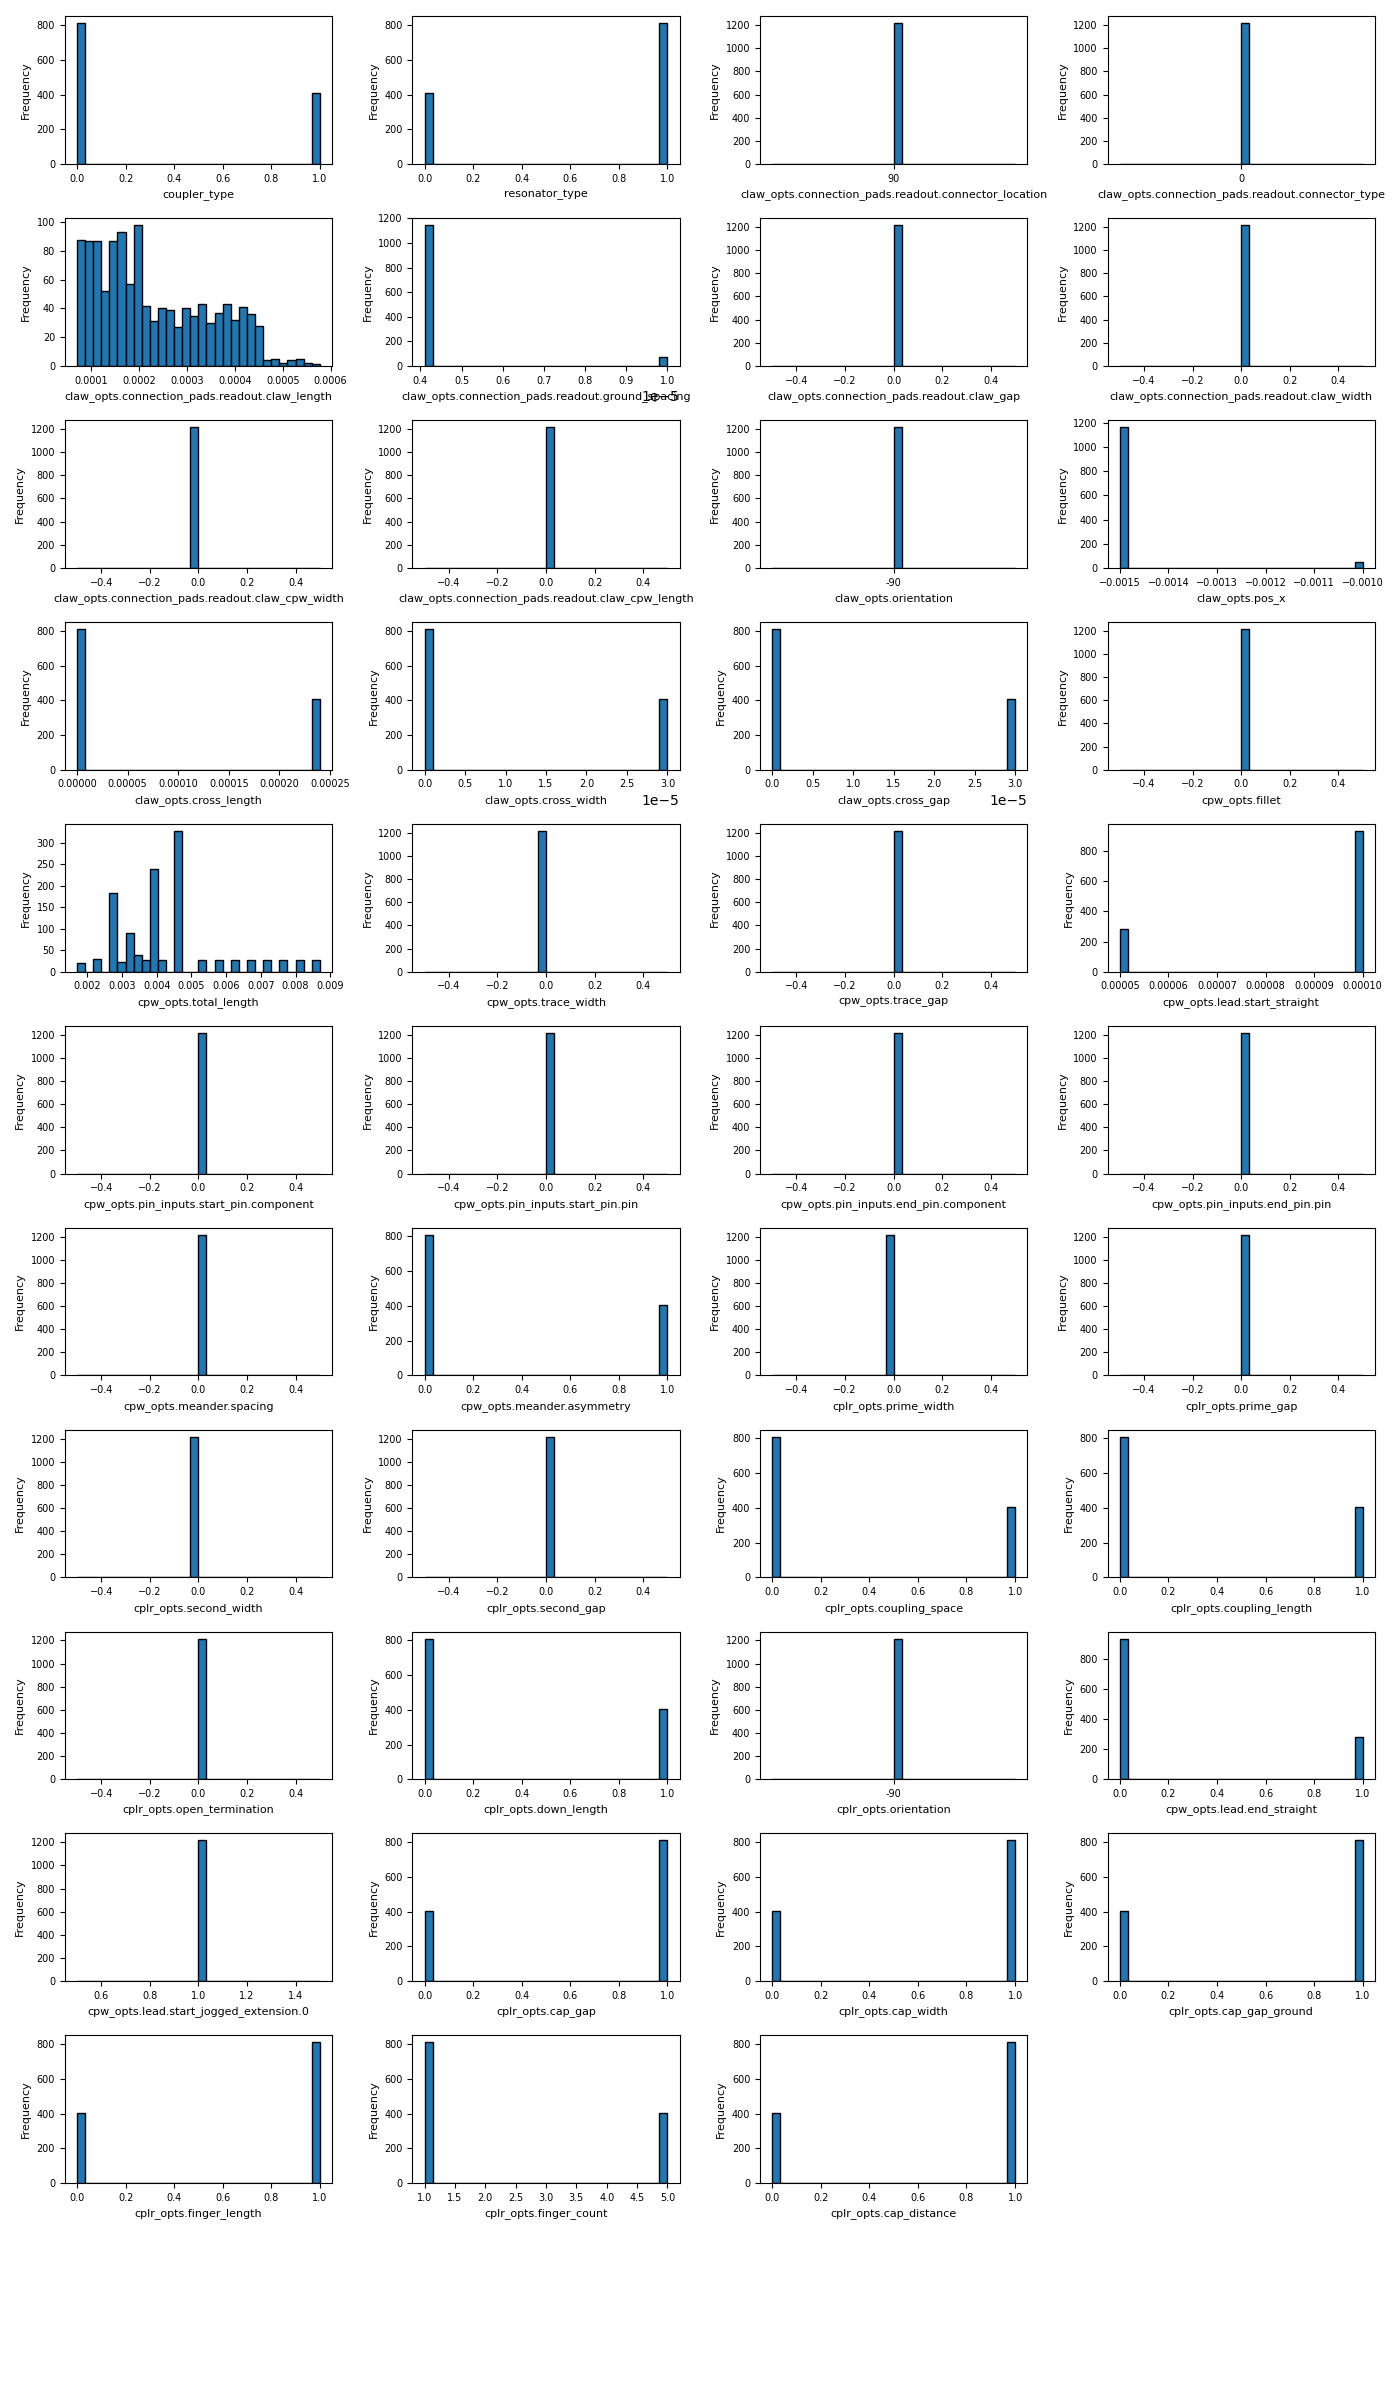

In [24]:
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_encoding_format[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [25]:
plt.close()

### X vs Y correlation plots

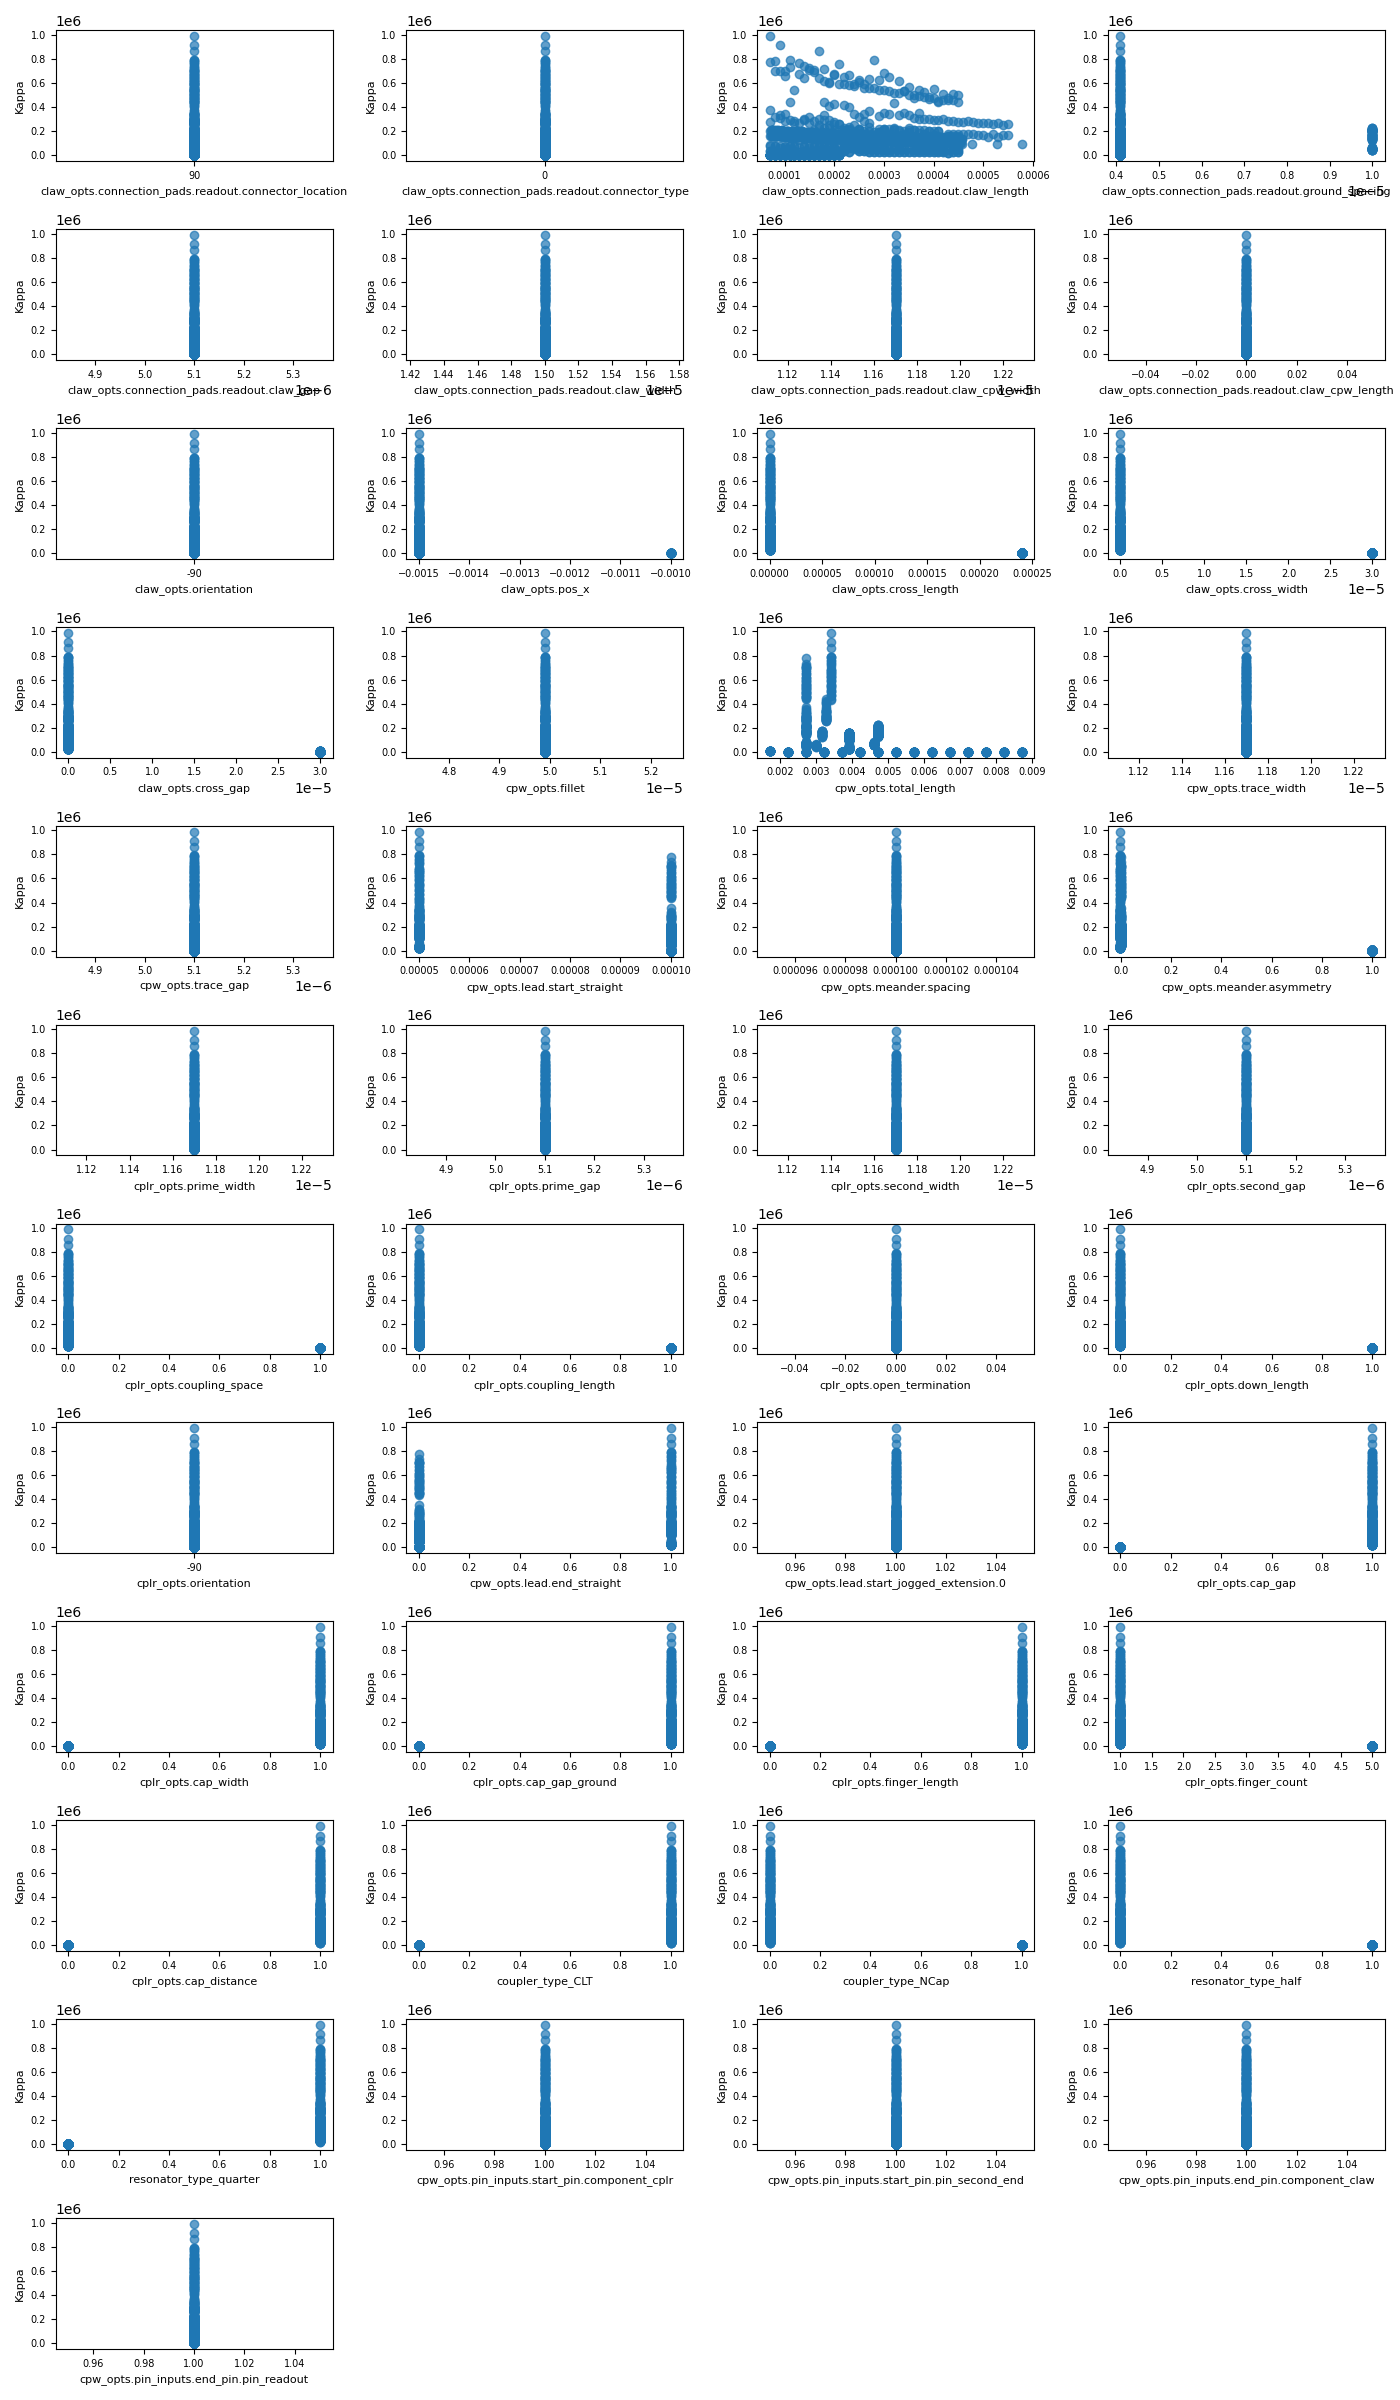

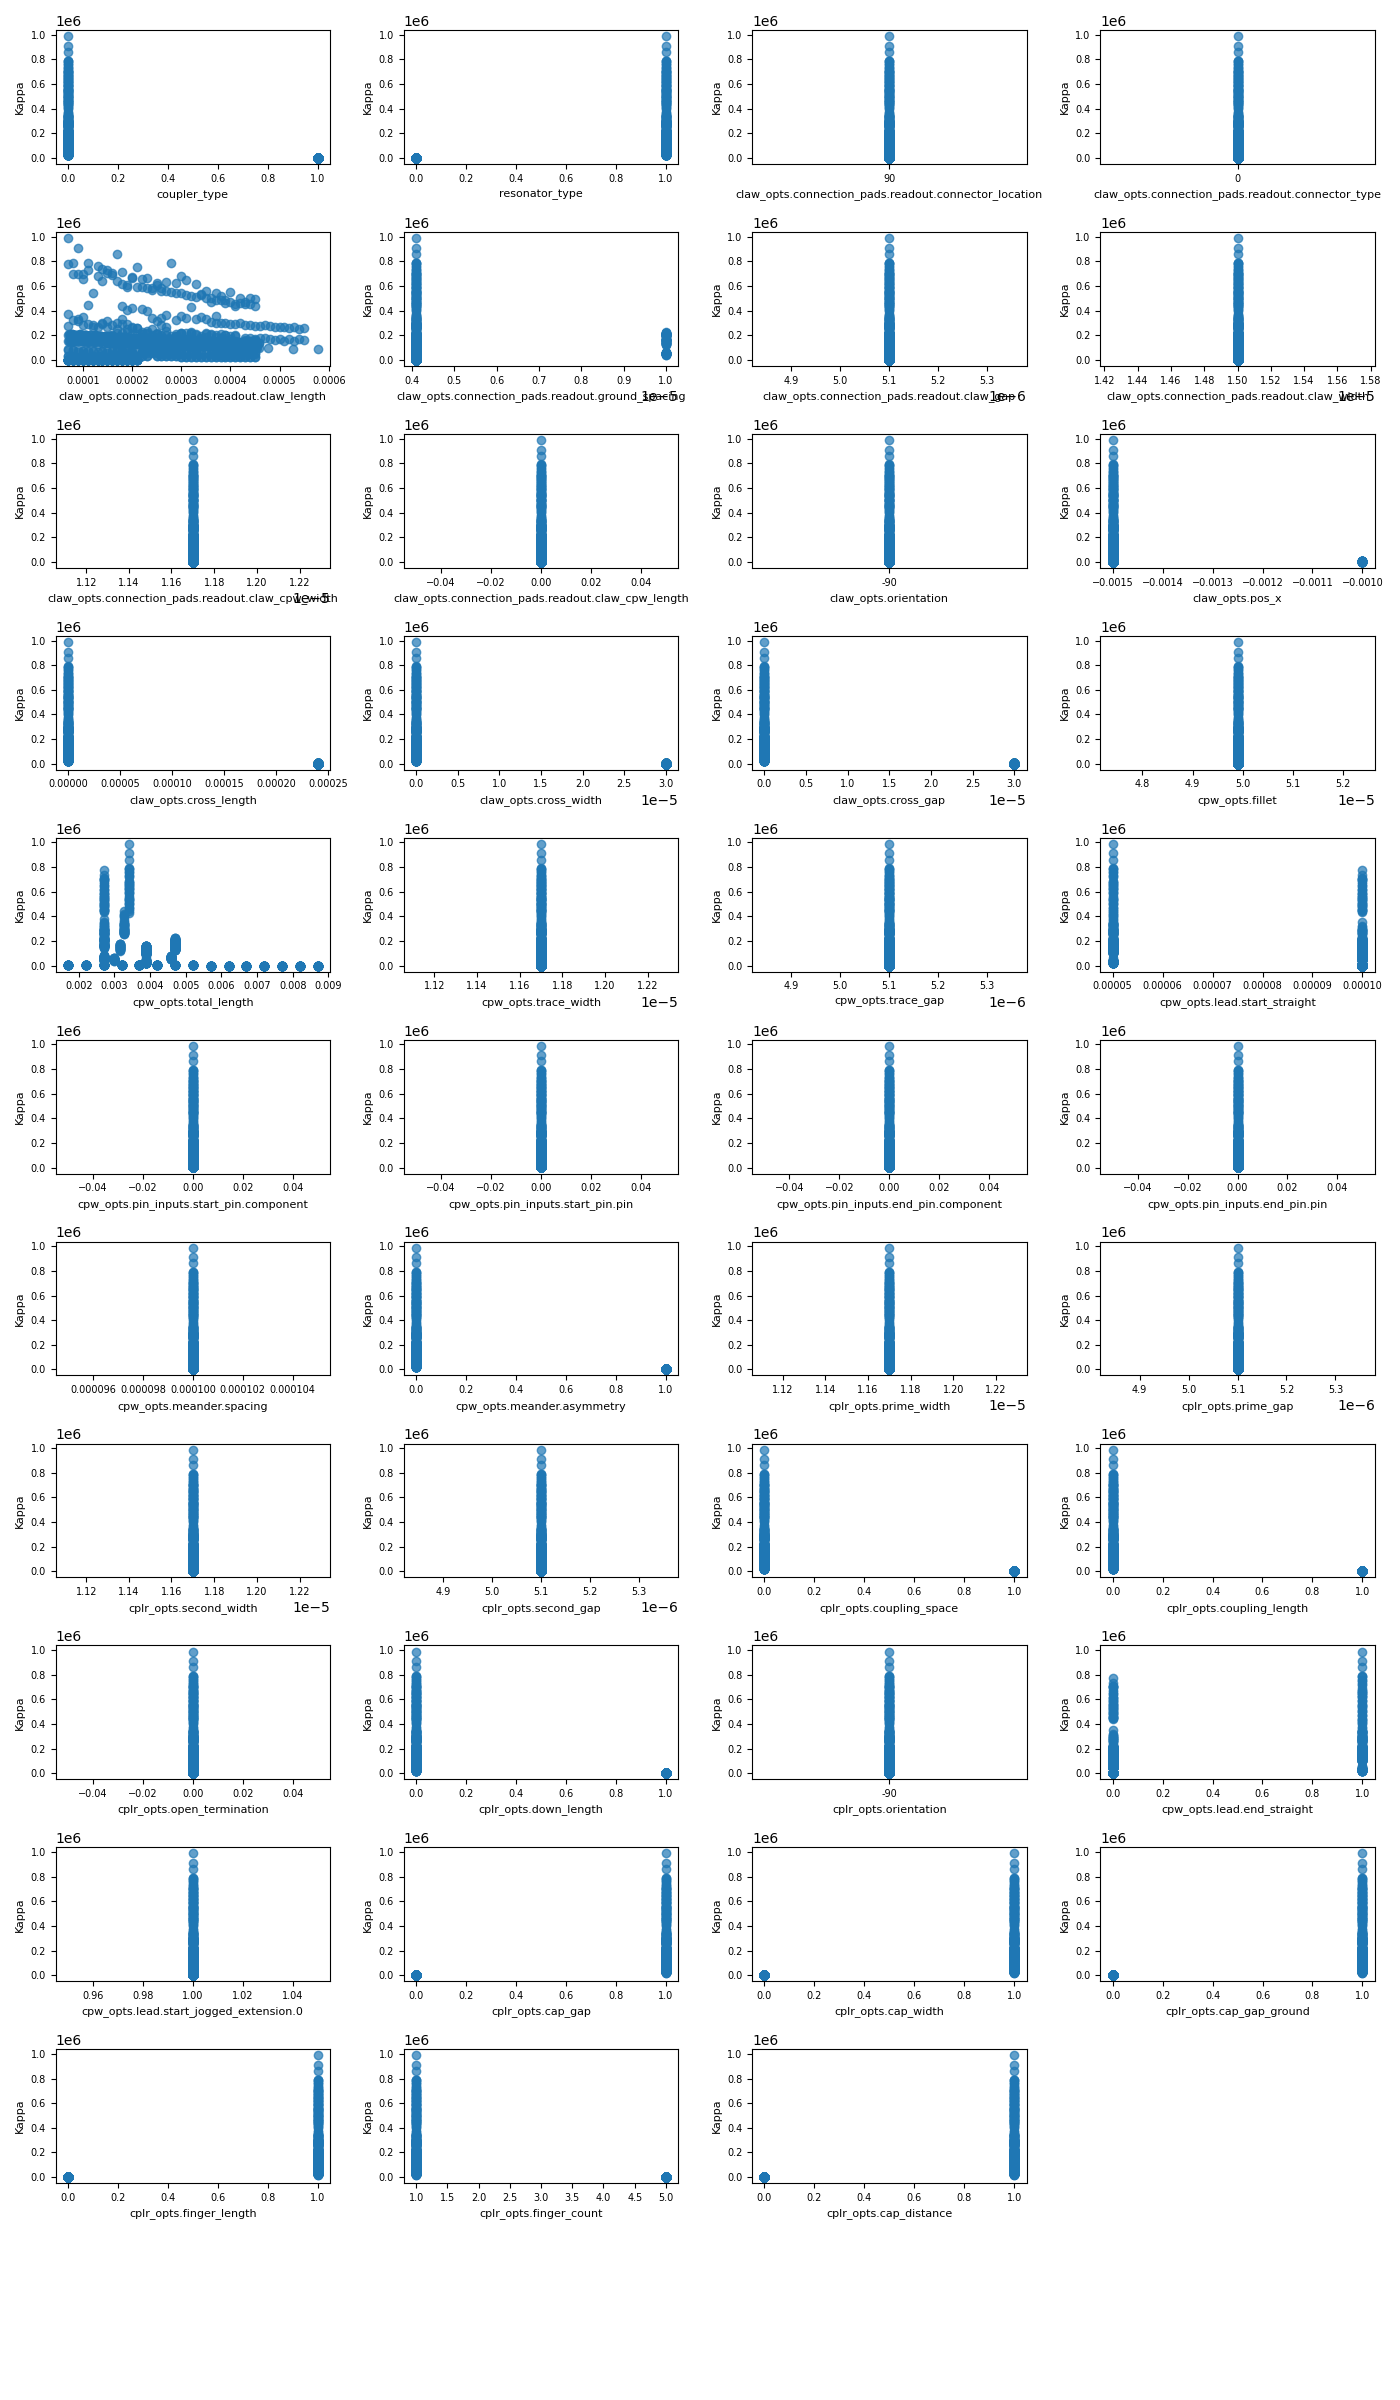

In [26]:
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_encoding_format[col], kappa_values, alpha=0.7) 
            plt.ylabel('Kappa', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_vs_kappa_correlation_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

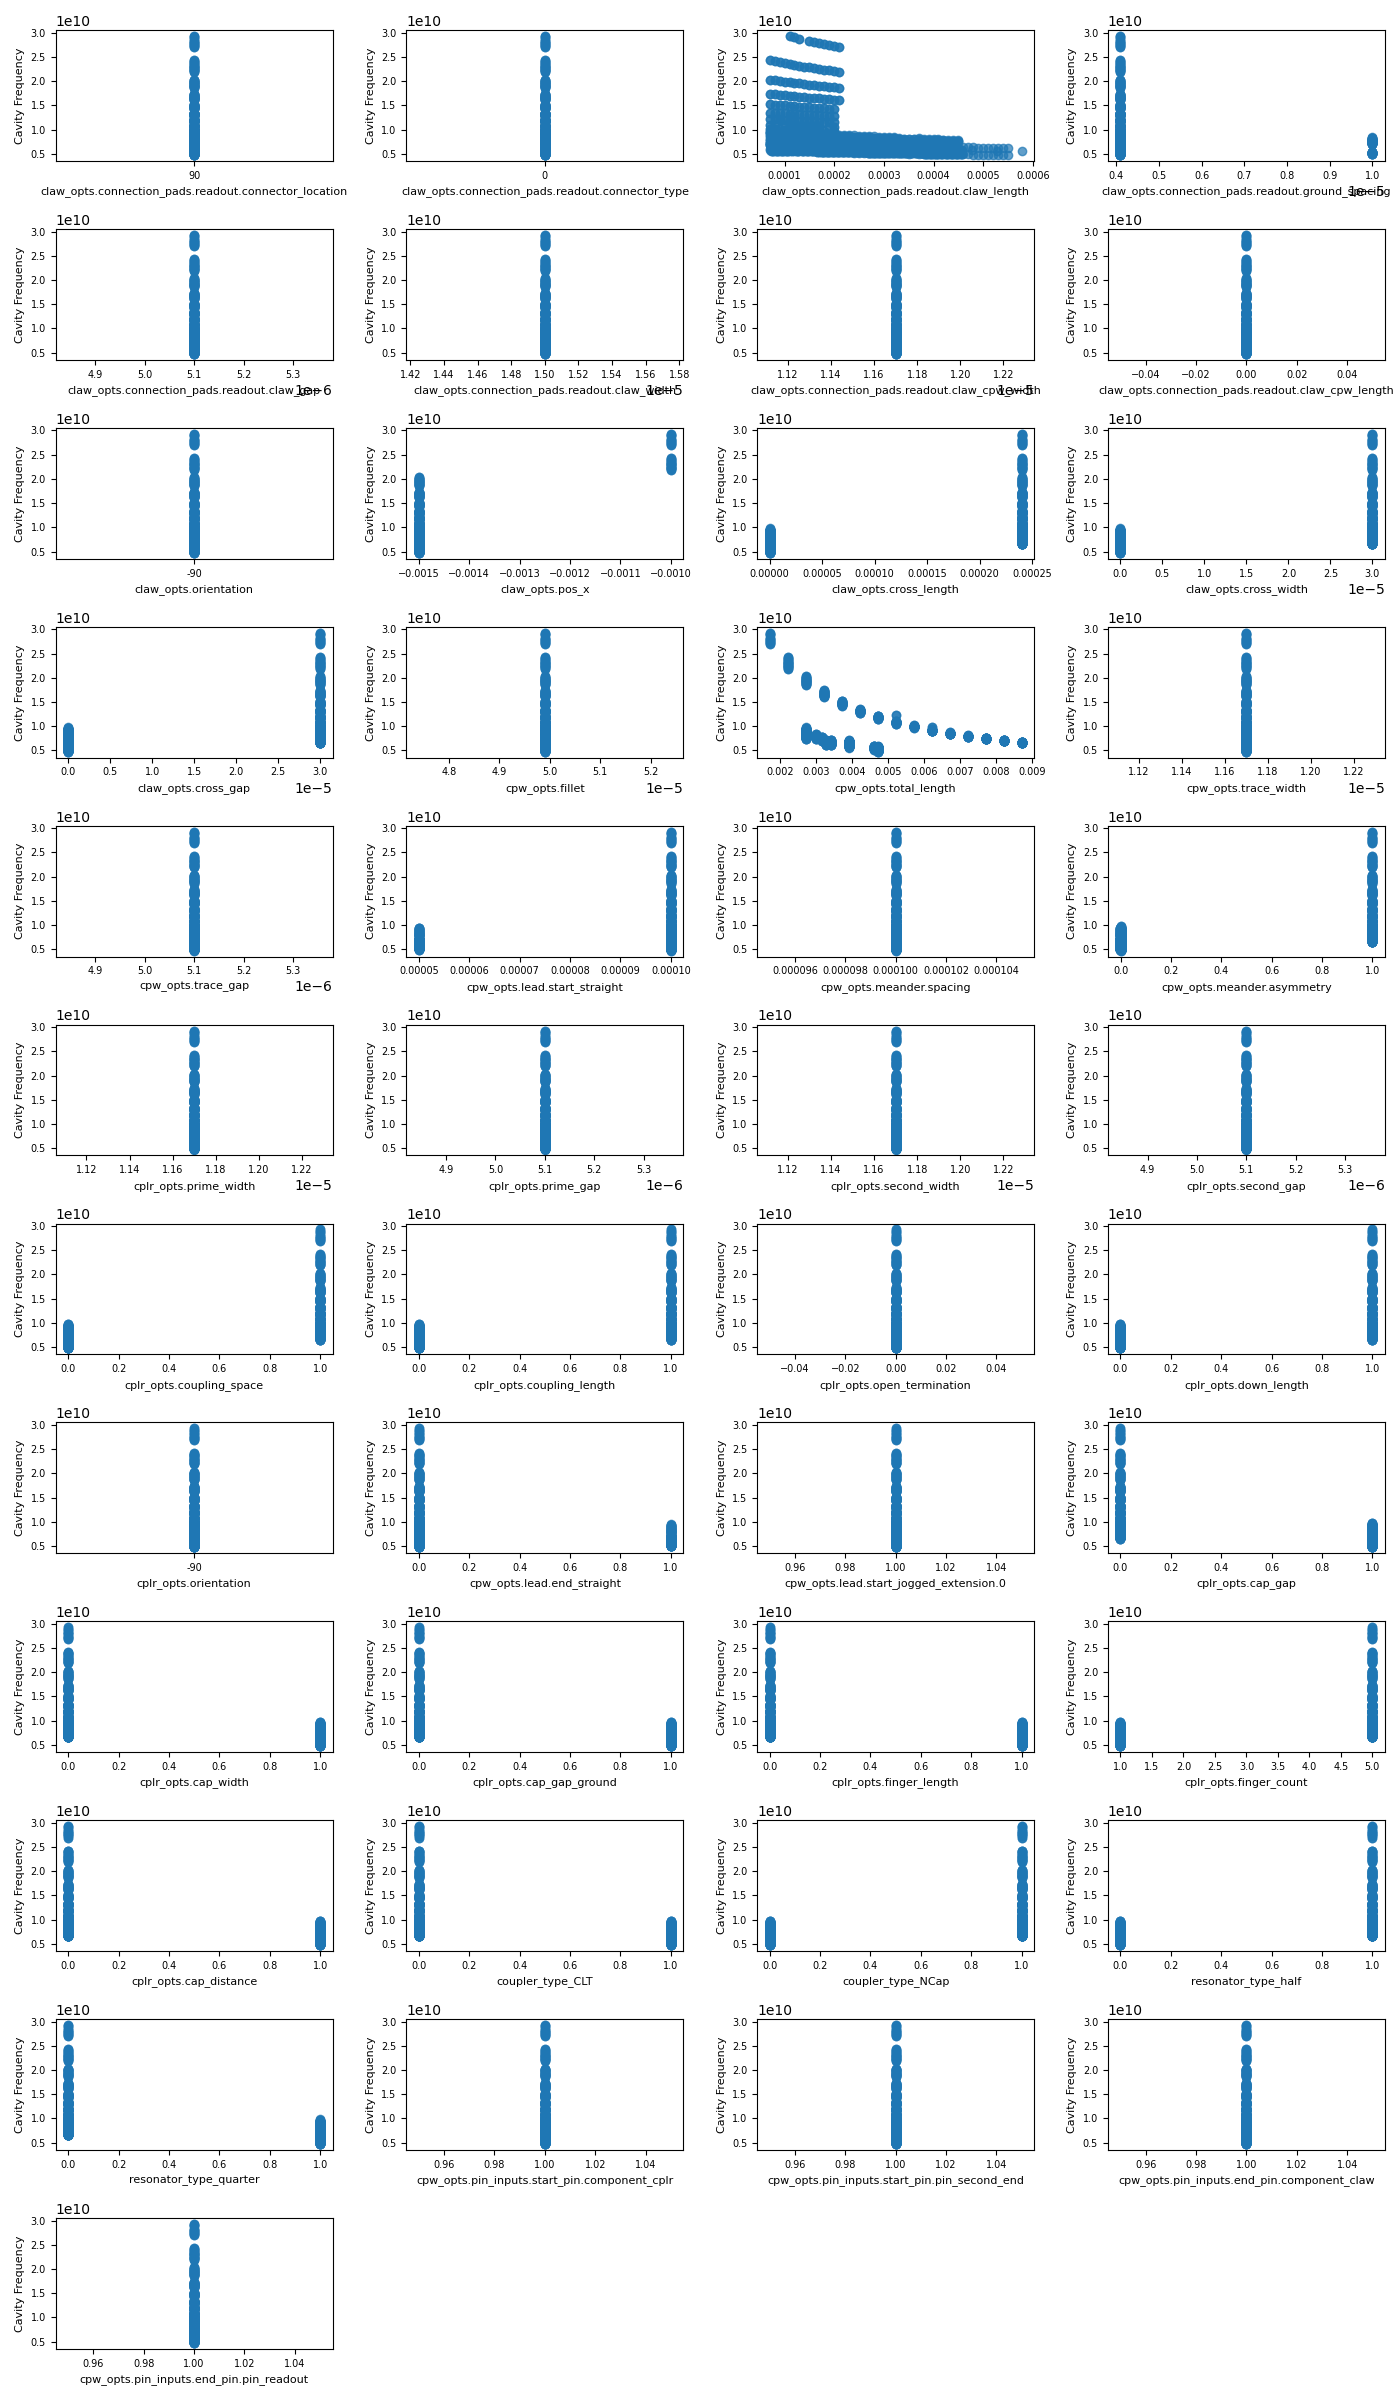

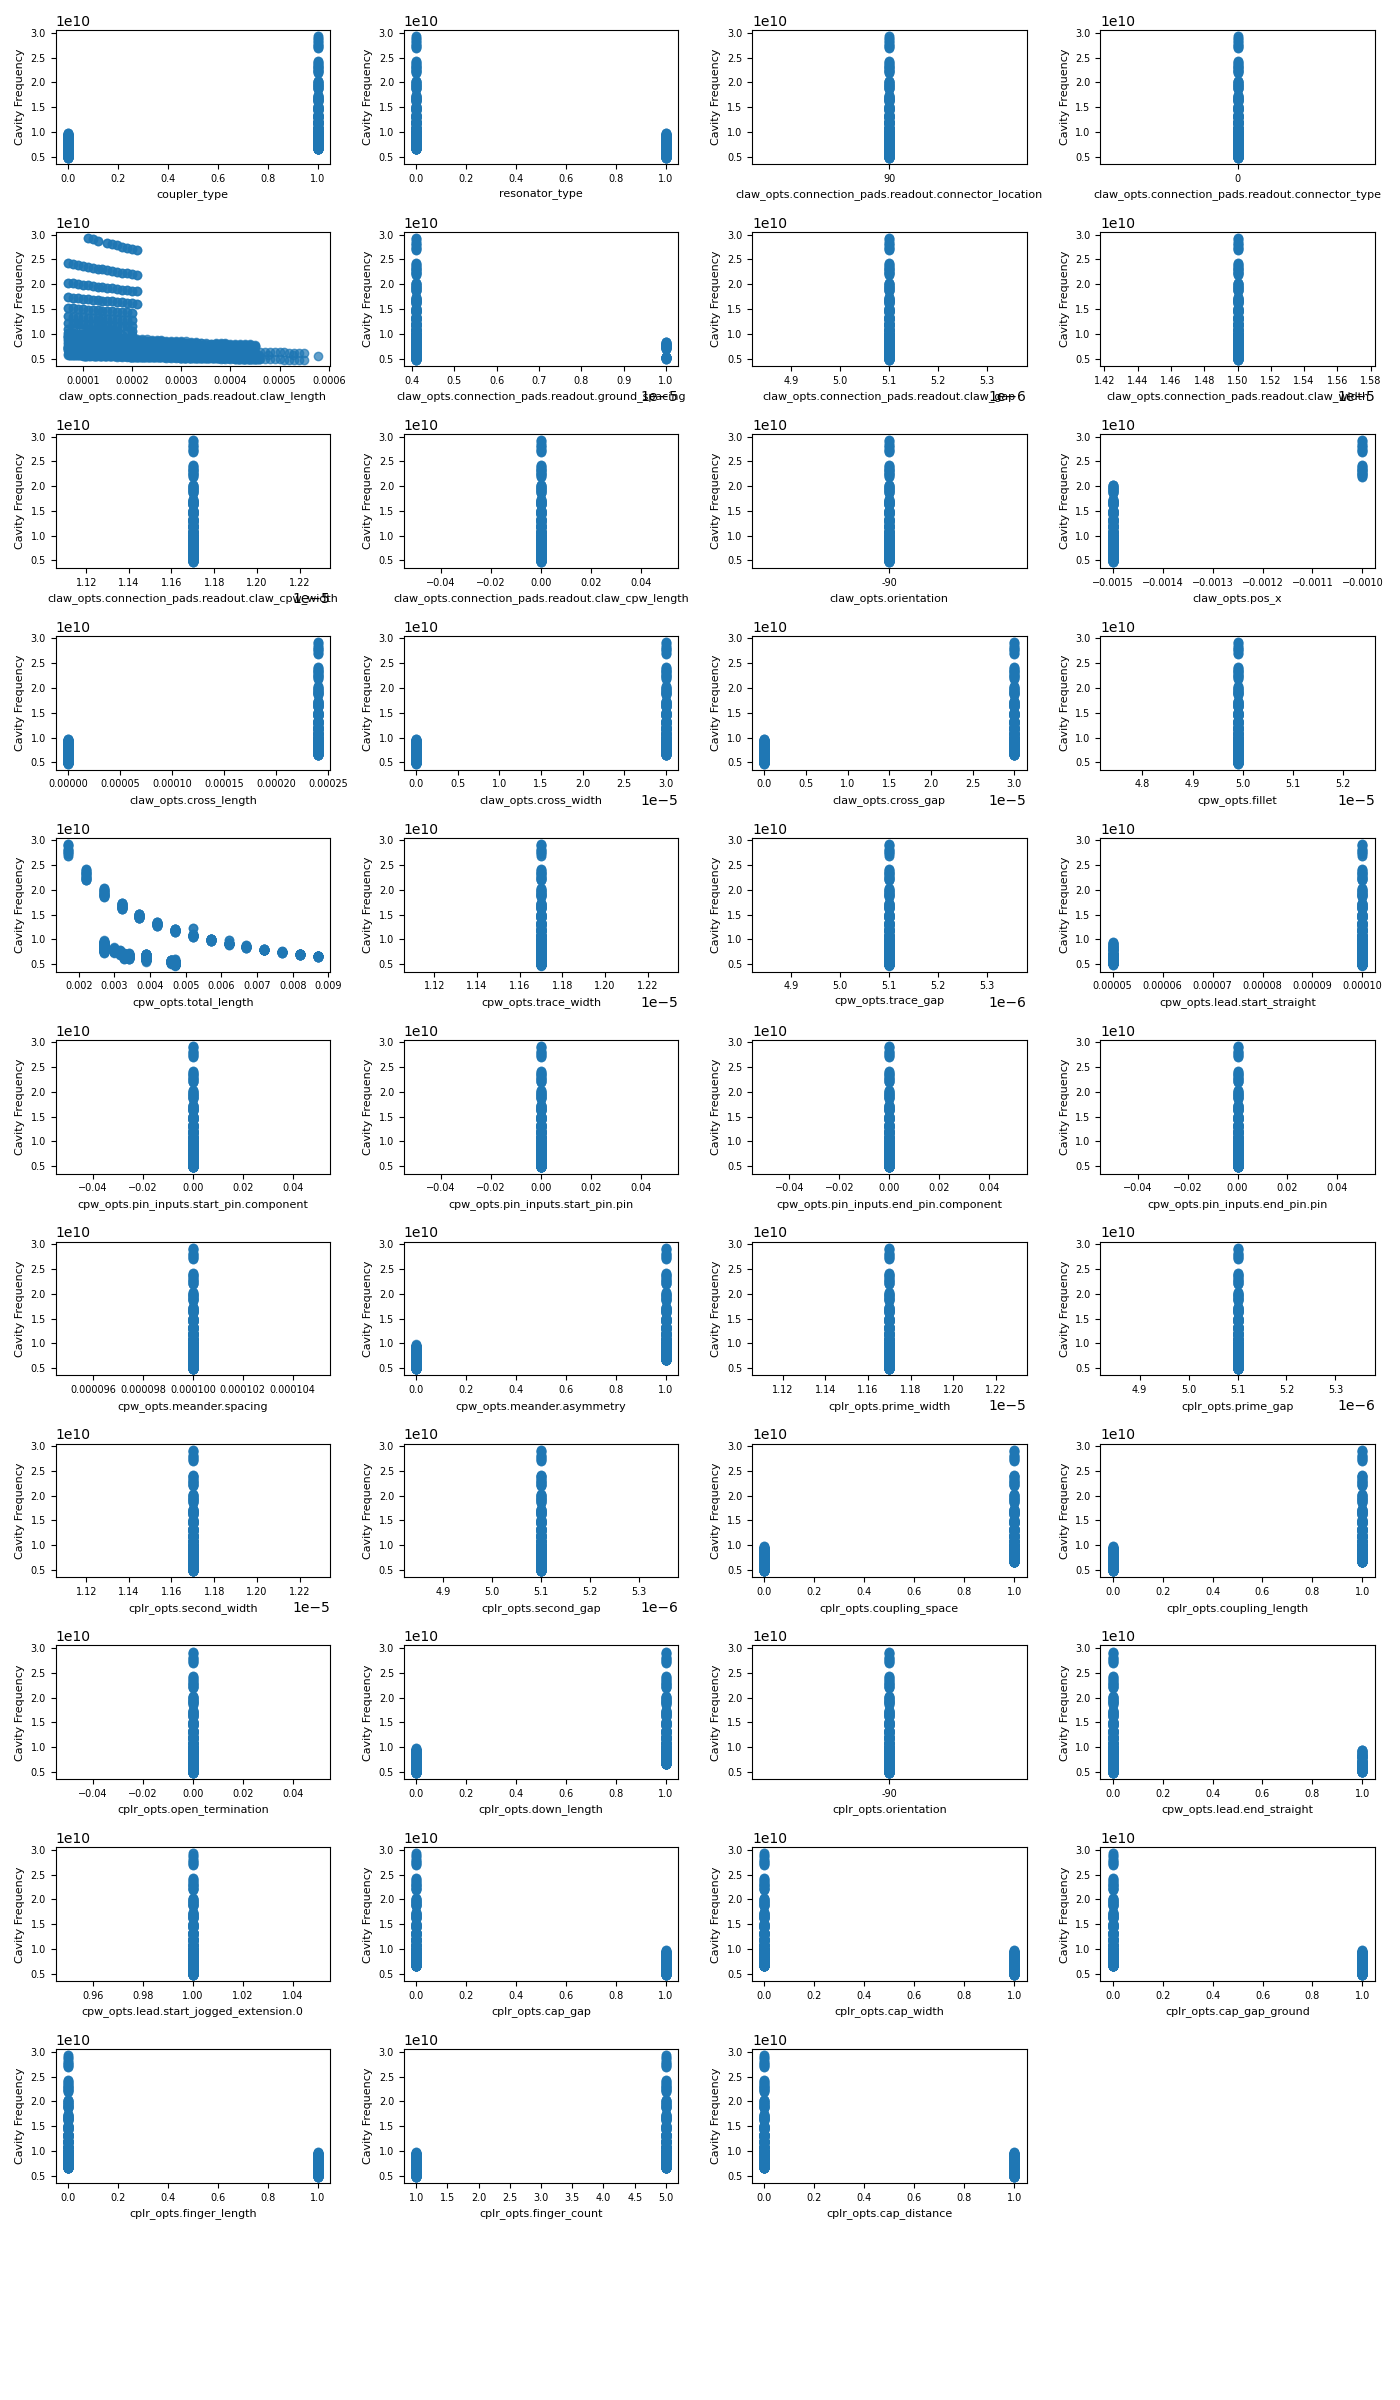

In [27]:
plt.close()
i=0
for y_encoding_format in y_encoding_formats:
    num_cols = len(y_encoding_format.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) 
    for n, col in enumerate(y_encoding_format.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.scatter(y_encoding_format[col], cavity_frequency_values, alpha=0.7) 
            plt.ylabel('Cavity Frequency', fontsize=8) 
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/unscaled_y_vs_cavity_freq_correlation_{y_encoding_format_names[i]}_encoding.png')
    #plt.show()
    i+=1

In [28]:
plt.close()

## Augment 

### Scale X

Scale kappa and frequency to be between 0 and 1

In [31]:
X_scaled = X.copy()
for col in X_scaled.columns:
    scaler = MinMaxScaler()
    X_scaled[col] = scaler.fit_transform(X_scaled[[col]]) #only fit to this column
    joblib.dump(scaler, f'scalers/scaler_X_{col}.save') #save for later

In [32]:
# Check the scaling
display(X_scaled)

cavity_frequency     kappa
0             0.025177  0.162590
1             0.149175  0.271163
2             0.161210  0.258476
3             0.076598  0.030401
4             0.132385  0.210345
...                ...       ...
1211          0.112145  0.046129
1212          0.110628  0.038877
1213          0.109137  0.046829
1214          0.107628  0.041597
1215          0.106133  0.058735

[1216 rows x 2 columns]

### Scale y

In [33]:
y_scaled_encoding_formats = []

i=0
for y_encoding_format in y_encoding_formats:
    y_scaled = y_encoding_format.copy()
    for col in y_scaled.columns:
        scaler = MinMaxScaler()
        y_scaled[col] = scaler.fit_transform(y_scaled[[col]]) #only fit to this column
        joblib.dump(scaler, f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save') #save for later
    y_scaled_encoding_formats.append(y_scaled)
    i+=1

### Plot Scaled Data

### X

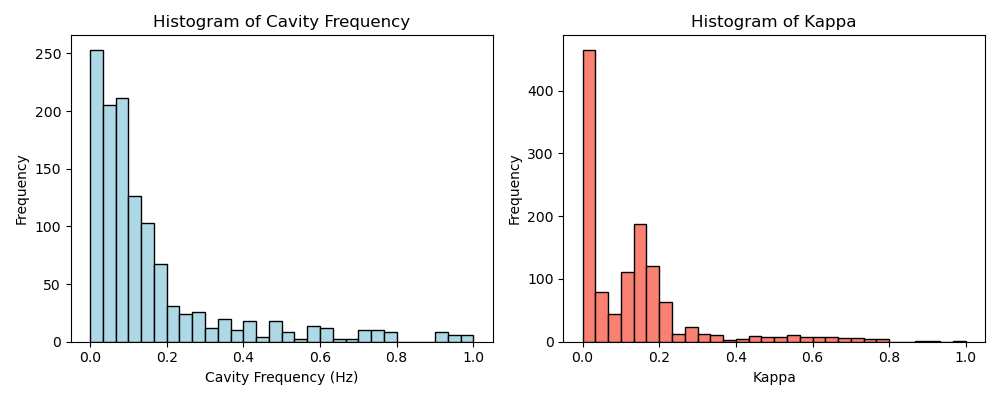

In [34]:
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X_scaled['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X_scaled['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [35]:
plt.savefig('plots/scaled_X_data.png')
plt.close()

In [36]:
plt.savefig('plots/scaled_X_data.png')
plt.close()

### Y

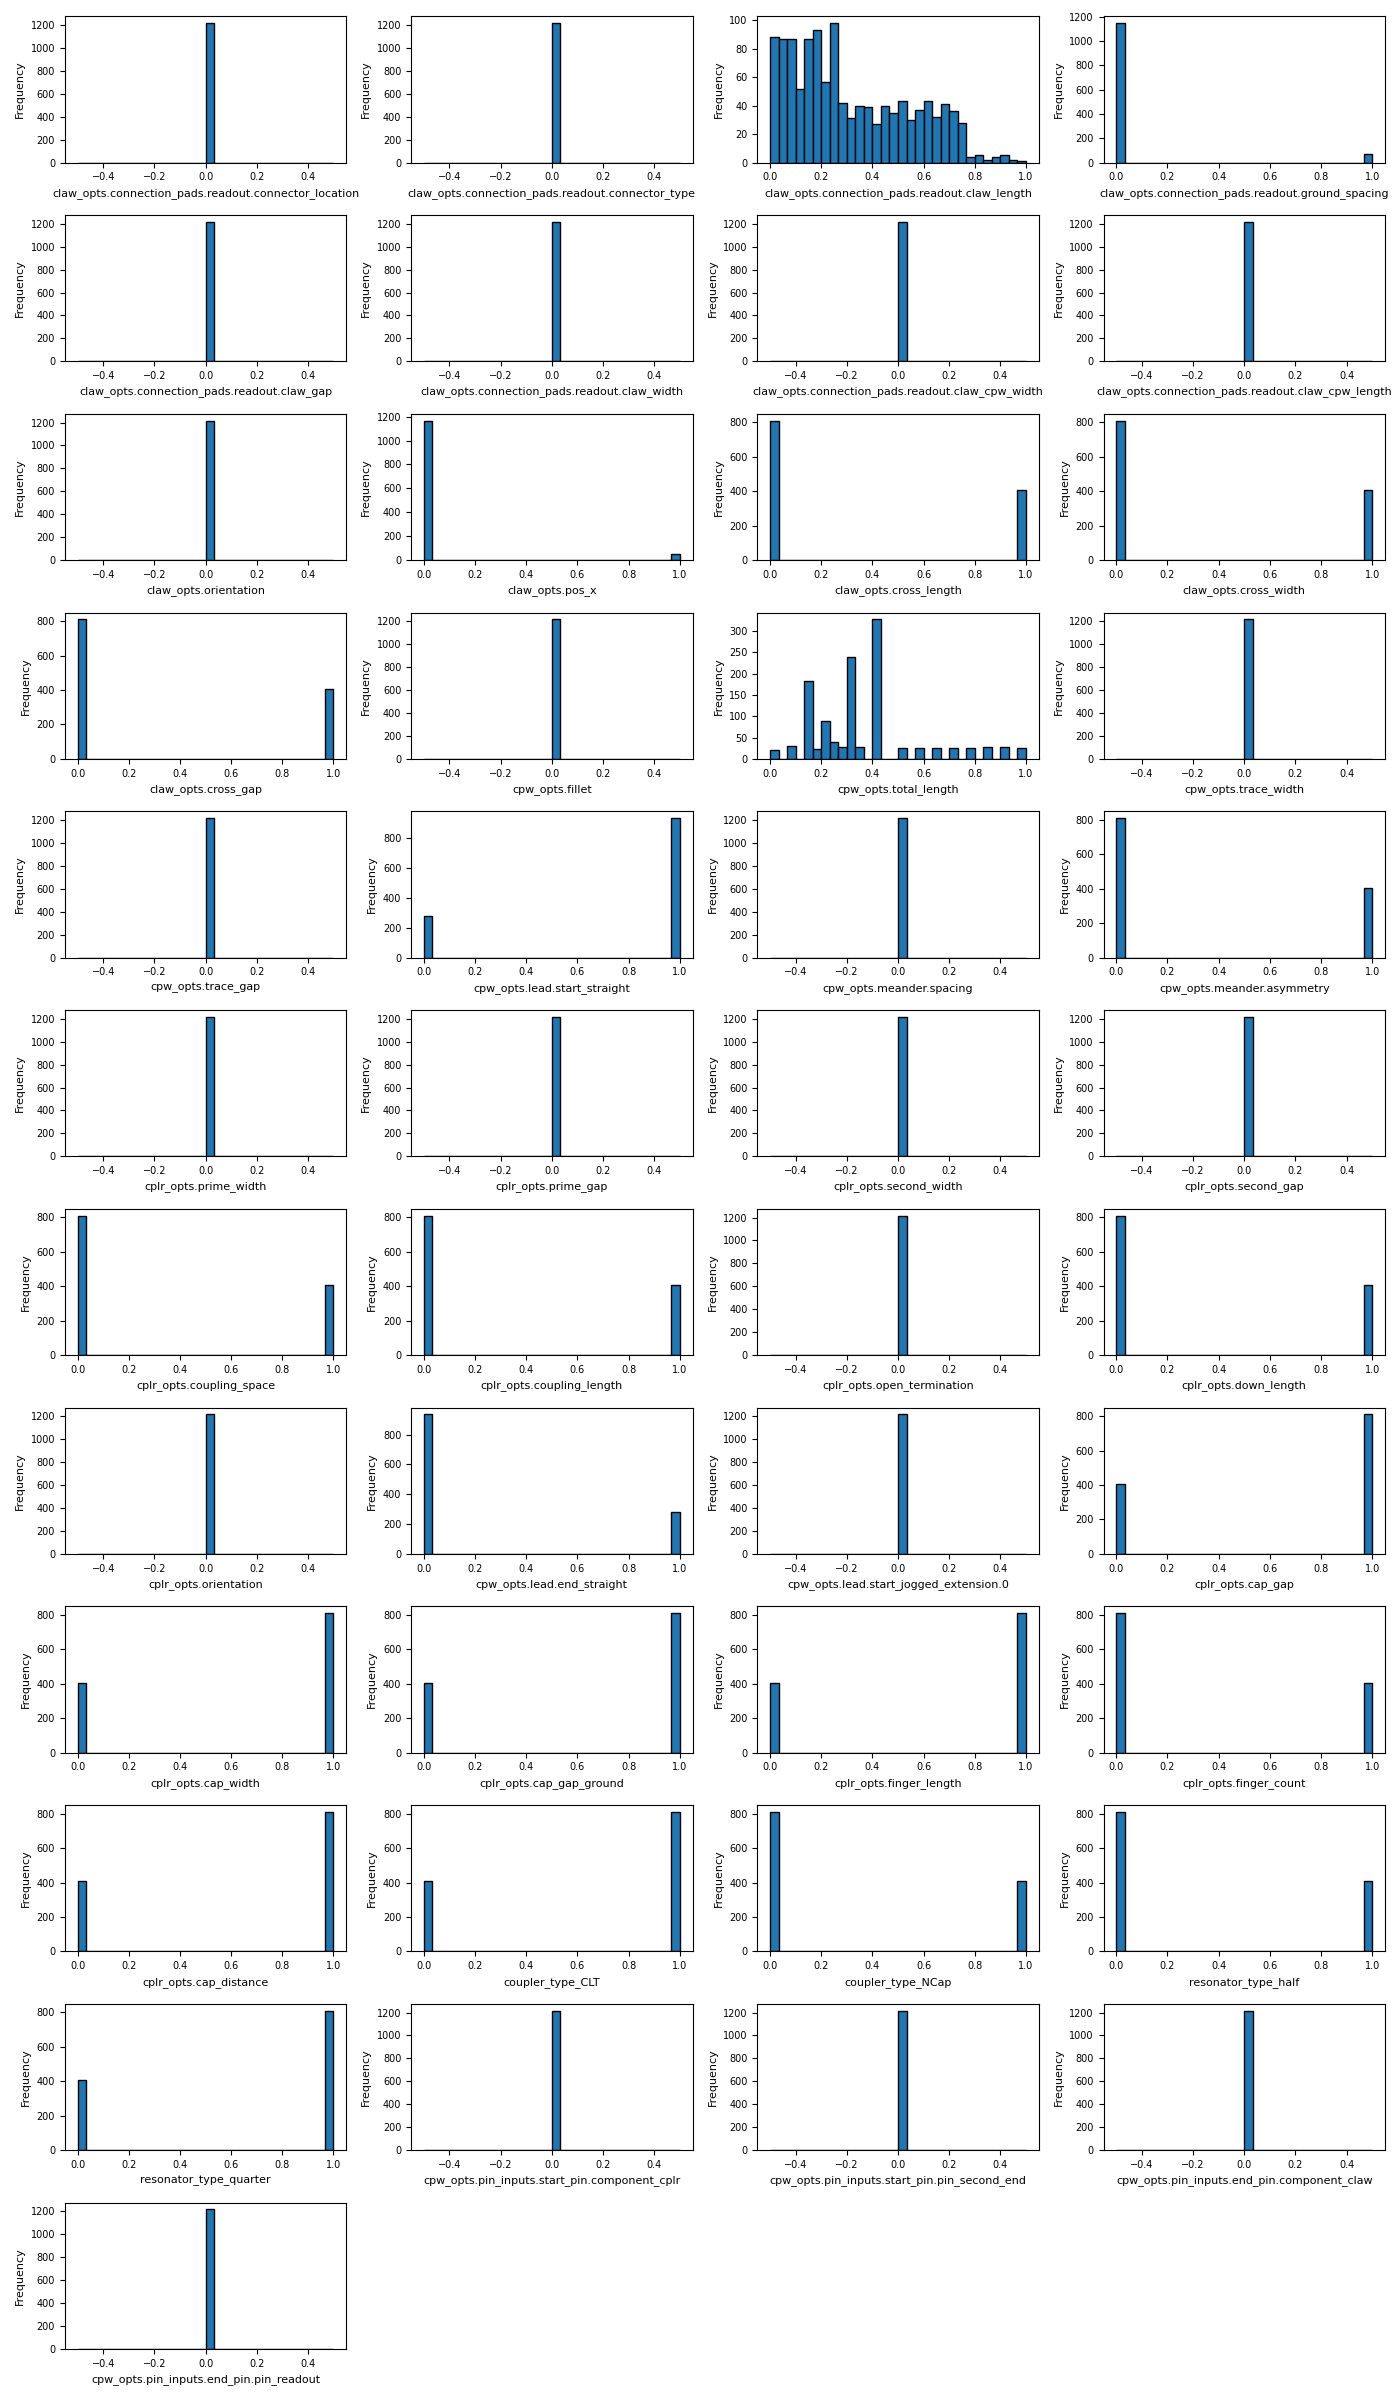

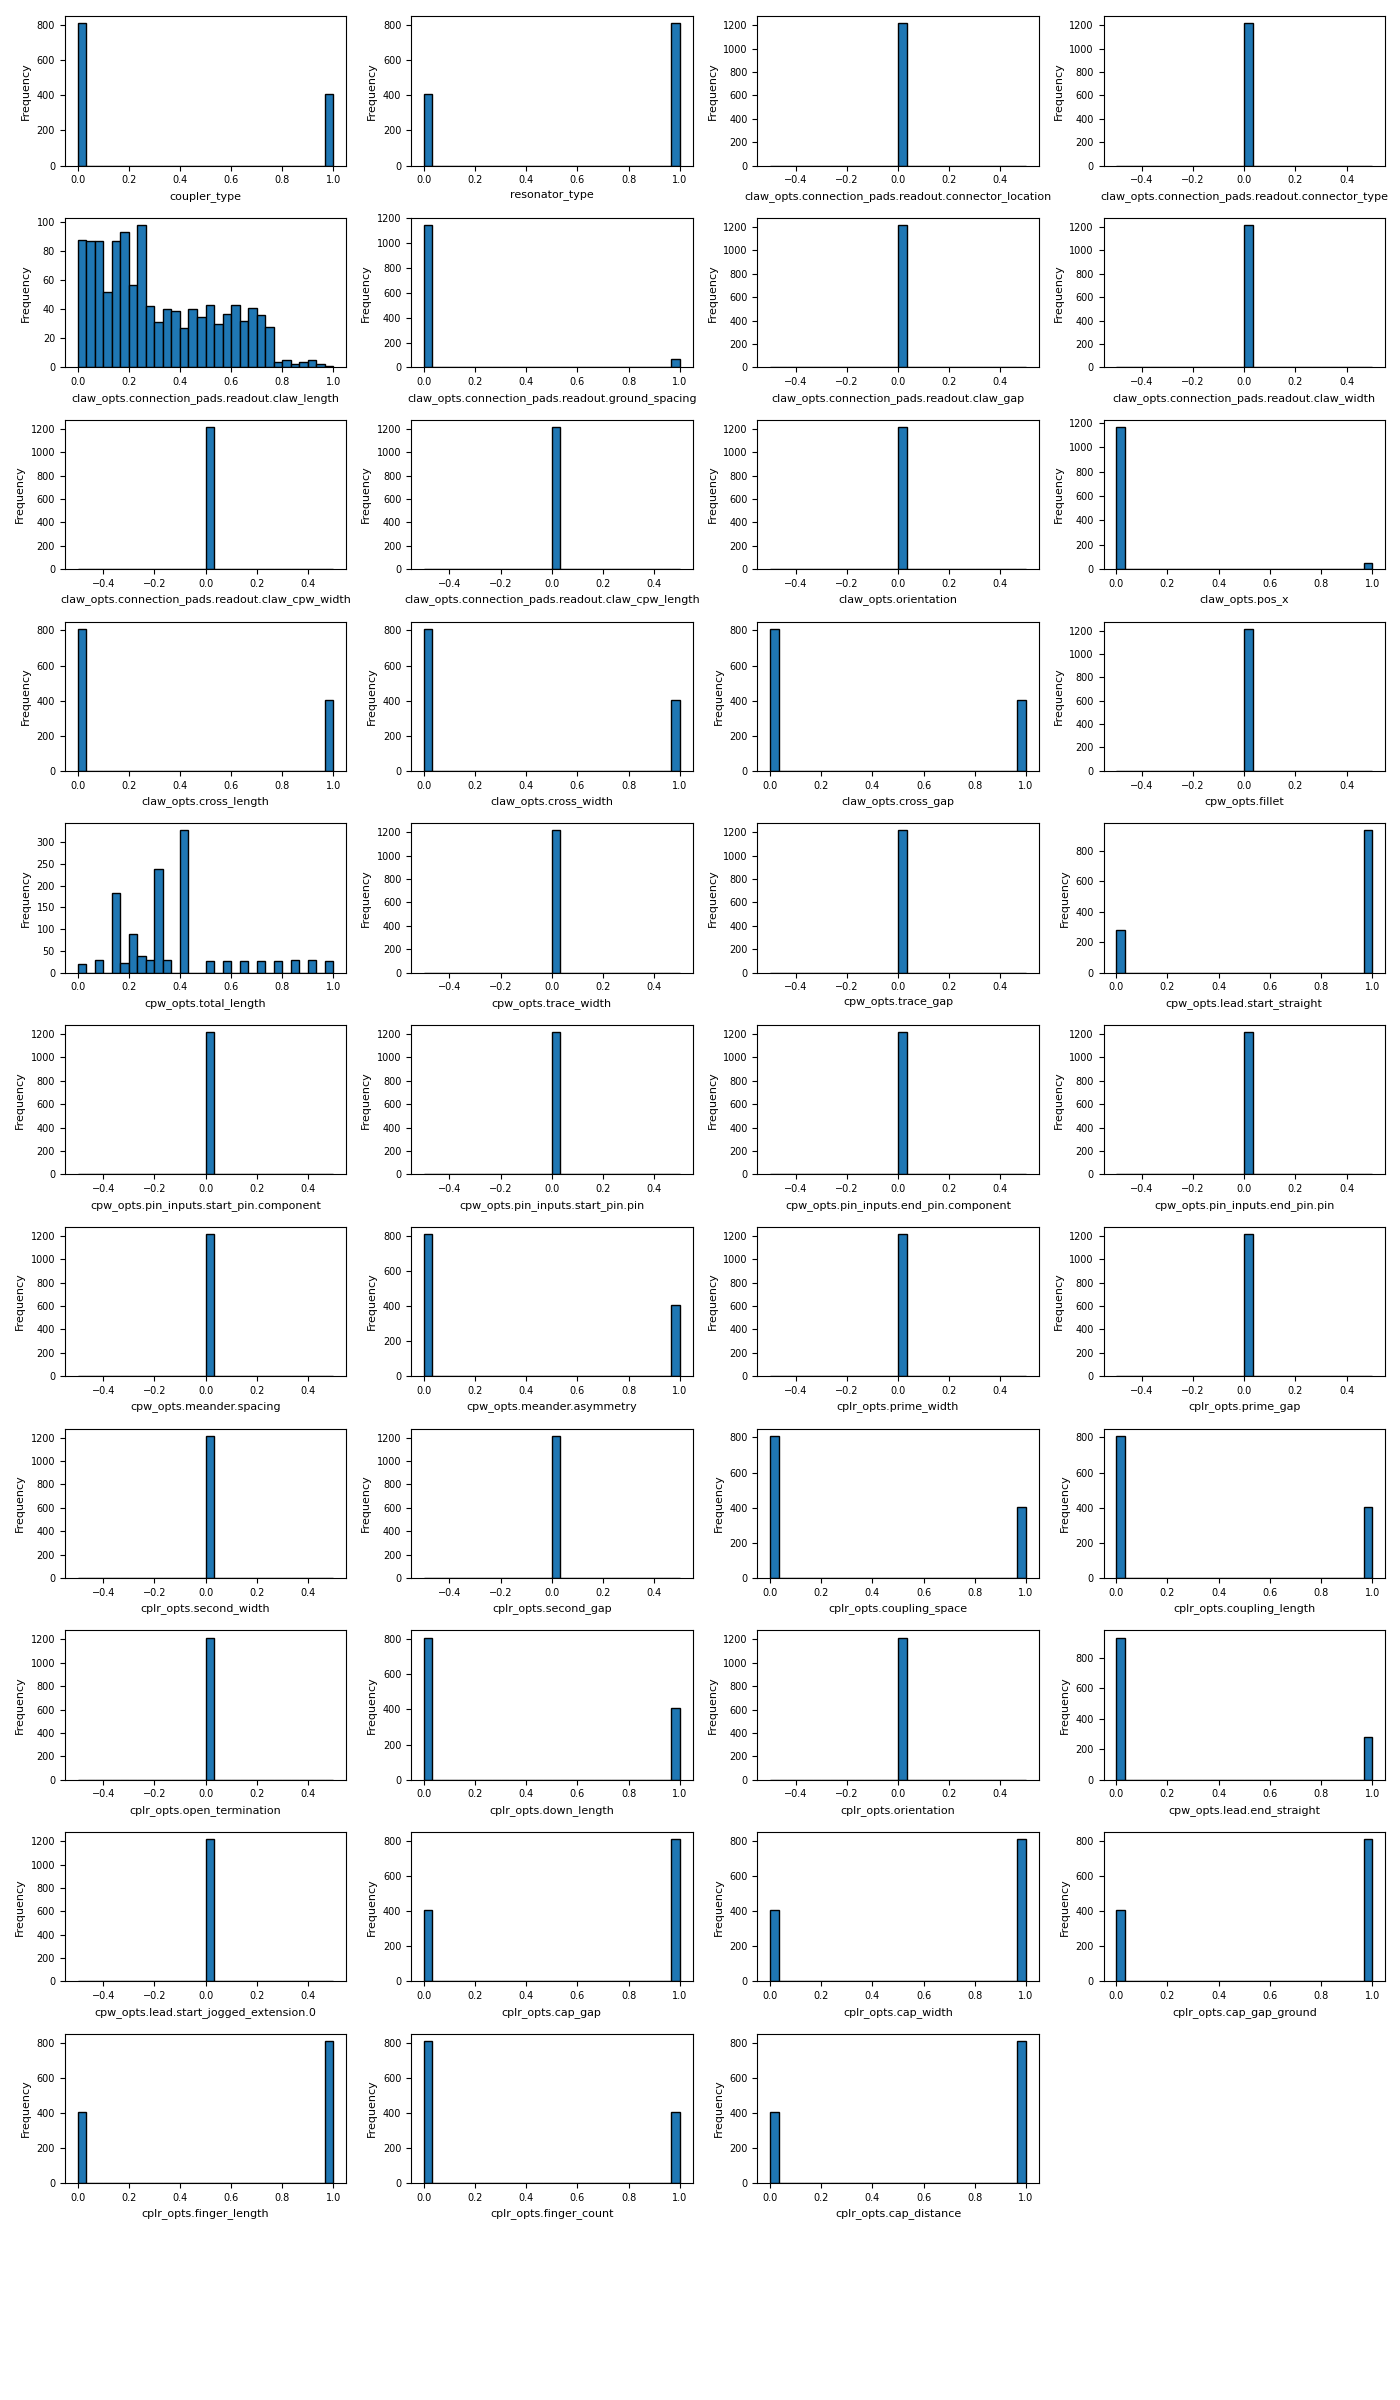

In [37]:
i=0
for y_scaled in y_scaled_encoding_formats:

    num_cols = len(y_scaled.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for n, col in enumerate(y_scaled.columns):
        try:
            plt.subplot(num_rows, 4, n + 1)
            plt.hist(y_scaled[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.savefig(f'plots/scaled_y_data_{y_encoding_format_names[i]}_encoding.png')
    plt.show()
    i+=1

In [38]:
plt.close()

### Unscale to make sure you can recreate original values with saved scaler

### Unscale X

In [39]:
X_orig = X_scaled.copy()
for col in X_scaled.columns:
    scaler = joblib.load(f'scalers/scaler_X_{col}.save')
    X_orig[col] = scaler.inverse_transform(X_scaled[[col]]) 

display(X_orig)

cavity_frequency          kappa
0         5.353550e+09  161106.598429
1         8.399241e+09  268412.116632
2         8.694845e+09  255873.654612
3         6.616574e+09   30459.761161
4         7.986835e+09  208304.221064
...                ...            ...
1211      7.489689e+09   46004.713078
1212      7.452442e+09   38837.211205
1213      7.415826e+09   46696.417529
1214      7.378752e+09   41526.048615
1215      7.342036e+09   58463.648381

[1216 rows x 2 columns]

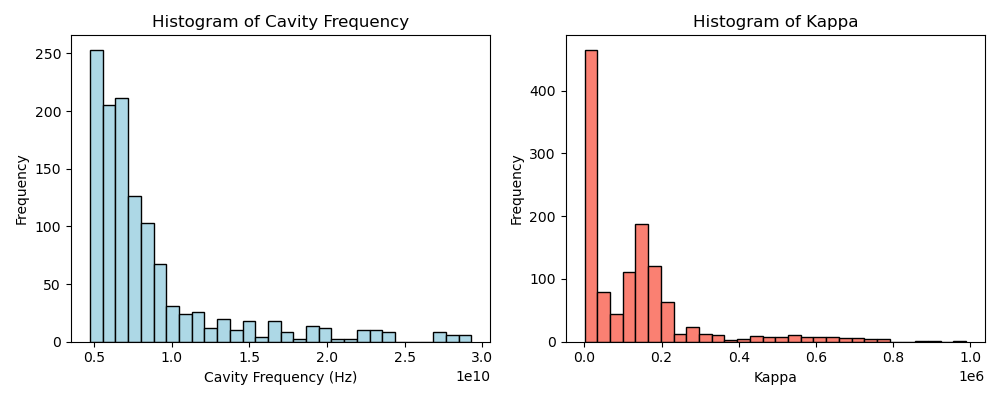

In [40]:
#plot again to see if you get same histgrams as pre-scaling
plt.figure(figsize=(10, 4))

# Histogram for Cavity Frequency
plt.subplot(1, 2, 1)
plt.hist(X_orig['cavity_frequency'], bins=30, color='lightblue', edgecolor='black')
plt.title('Histogram of Cavity Frequency')
plt.xlabel('Cavity Frequency (Hz)')
plt.ylabel('Frequency')

# Histogram for Kappa
plt.subplot(1, 2, 2)
plt.hist(X_orig['kappa'], bins=30, color='salmon', edgecolor='black')
plt.title('Histogram of Kappa')
plt.xlabel('Kappa')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Unscale Y

In [41]:
y_orig_encoding_formats = []

i=0
for y_scaled in y_scaled_encoding_formats:
    y_orig = y_scaled.copy()
    for col in y_scaled.columns:
        scaler = joblib.load(f'scalers/scaler_y_{col}_{y_encoding_format_names[i]}_encoding.save')
        y_orig[col] = scaler.inverse_transform(y_scaled[[col]])
    y_orig_encoding_formats.append(y_orig)
    print('Encoding Type: ', y_encoding_format_names[i])
    display(y_orig)
    print('\n')
    i+=1

Encoding Type:  one_hot


design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                  90.0                     
1                                                  90.0                     
2                                                  90.0                     
3                                                  90.0                     
4                                                  90.0                     
...                                                 ...                     
1211                                               90.0                     
1212                                               90.0                     
1213                                               90.0                     
1214                                               90.0                     
1215                                               90.0                     

      design_options.claw_opts.connection_pads.readout.connector_type  \
0                                                   0.0                 
1                                                   0.0                 
2                                                   0.0                 
3                                                   0.0                 
4                                                   0.0                 
...                                                 ...                 
1211                                                0.0                 
1212                                                0.0                 
1213                                                0.0                 
1214                                                0.0                 
1215                                                0.0                 

      design_options.claw_opts.connection_pads.readout.claw_length  \
0                                               0.00022              
1                                               0.00027              
2                                               0.00021              
3                                               0.00021              
4                                               0.00036              
...                                                 ...              
1211                                            0.00038              
1212                                            0.00039              
1213                                            0.00040              
1214                                            0.00041              
1215                                            0.00042              

      design_options.claw_opts.connection_pads.readout.ground_spacing  \
0                                              0.000004                 
1                                              0.000004                 
2                                              0.000004                 
3                                              0.000004                 
4                                              0.000004                 
...                                                 ...                 
1211                                           0.000010                 
1212                                           0.000010                 
1213                                           0.000010                 
1214                                           0.000010                 
1215                                           0.000010                 

      design_options.claw_opts.connection_pads.readout.claw_gap  \
0                                              0.000005           
1                                              0.000005           
2                                              0.000005           
3                                              0.000005           
4                                              0.000005           
...                                                 ...           
1211             



Encoding Type:  linear


coupler_type  resonator_type  \
0              0.0             1.0   
1              0.0             1.0   
2              0.0             1.0   
3              0.0             1.0   
4              0.0             1.0   
...            ...             ...   
1211           0.0             1.0   
1212           0.0             1.0   
1213           0.0             1.0   
1214           0.0             1.0   
1215           0.0             1.0   

      design_options.claw_opts.connection_pads.readout.connector_location  \
0                                                  90.0                     
1                                                  90.0                     
2                                                  90.0                     
3                                                  90.0                     
4                                                  90.0                     
...                                                 ...                     
1211                                               90.0                     
1212                                               90.0                     
1213                                               90.0                     
1214                                               90.0                     
1215                                               90.0                     

      design_options.claw_opts.connection_pads.readout.connector_type  \
0                                                   0.0                 
1                                                   0.0                 
2                                                   0.0                 
3                                                   0.0                 
4                                                   0.0                 
...                                                 ...                 
1211                                                0.0                 
1212                                                0.0                 
1213                                                0.0                 
1214                                                0.0                 
1215                                                0.0                 

      design_options.claw_opts.connection_pads.readout.claw_length  \
0                                               0.00022              
1                                               0.00027              
2                                               0.00021              
3                                               0.00021              
4                                               0.00036              
...                                                 ...              
1211                                            0.00038              
1212                                            0.00039              
1213                                            0.00040              
1214                                            0.00041              
1215                                            0.00042              

      design_options.claw_opts.connection_pads.readout.ground_spacing  \
0                                              0.000004                 
1                                              0.000004                 
2                                              0.000004                 
3                                              0.000004                 
4                                              0.000004                 
...                                                 ...                 
1211                                           0.000010                 
1212                                           0.000010                 
1213                                           0.000010                 
1214                                           0.000010                 
1215                                           0.000010                 

      design_options.claw_opt

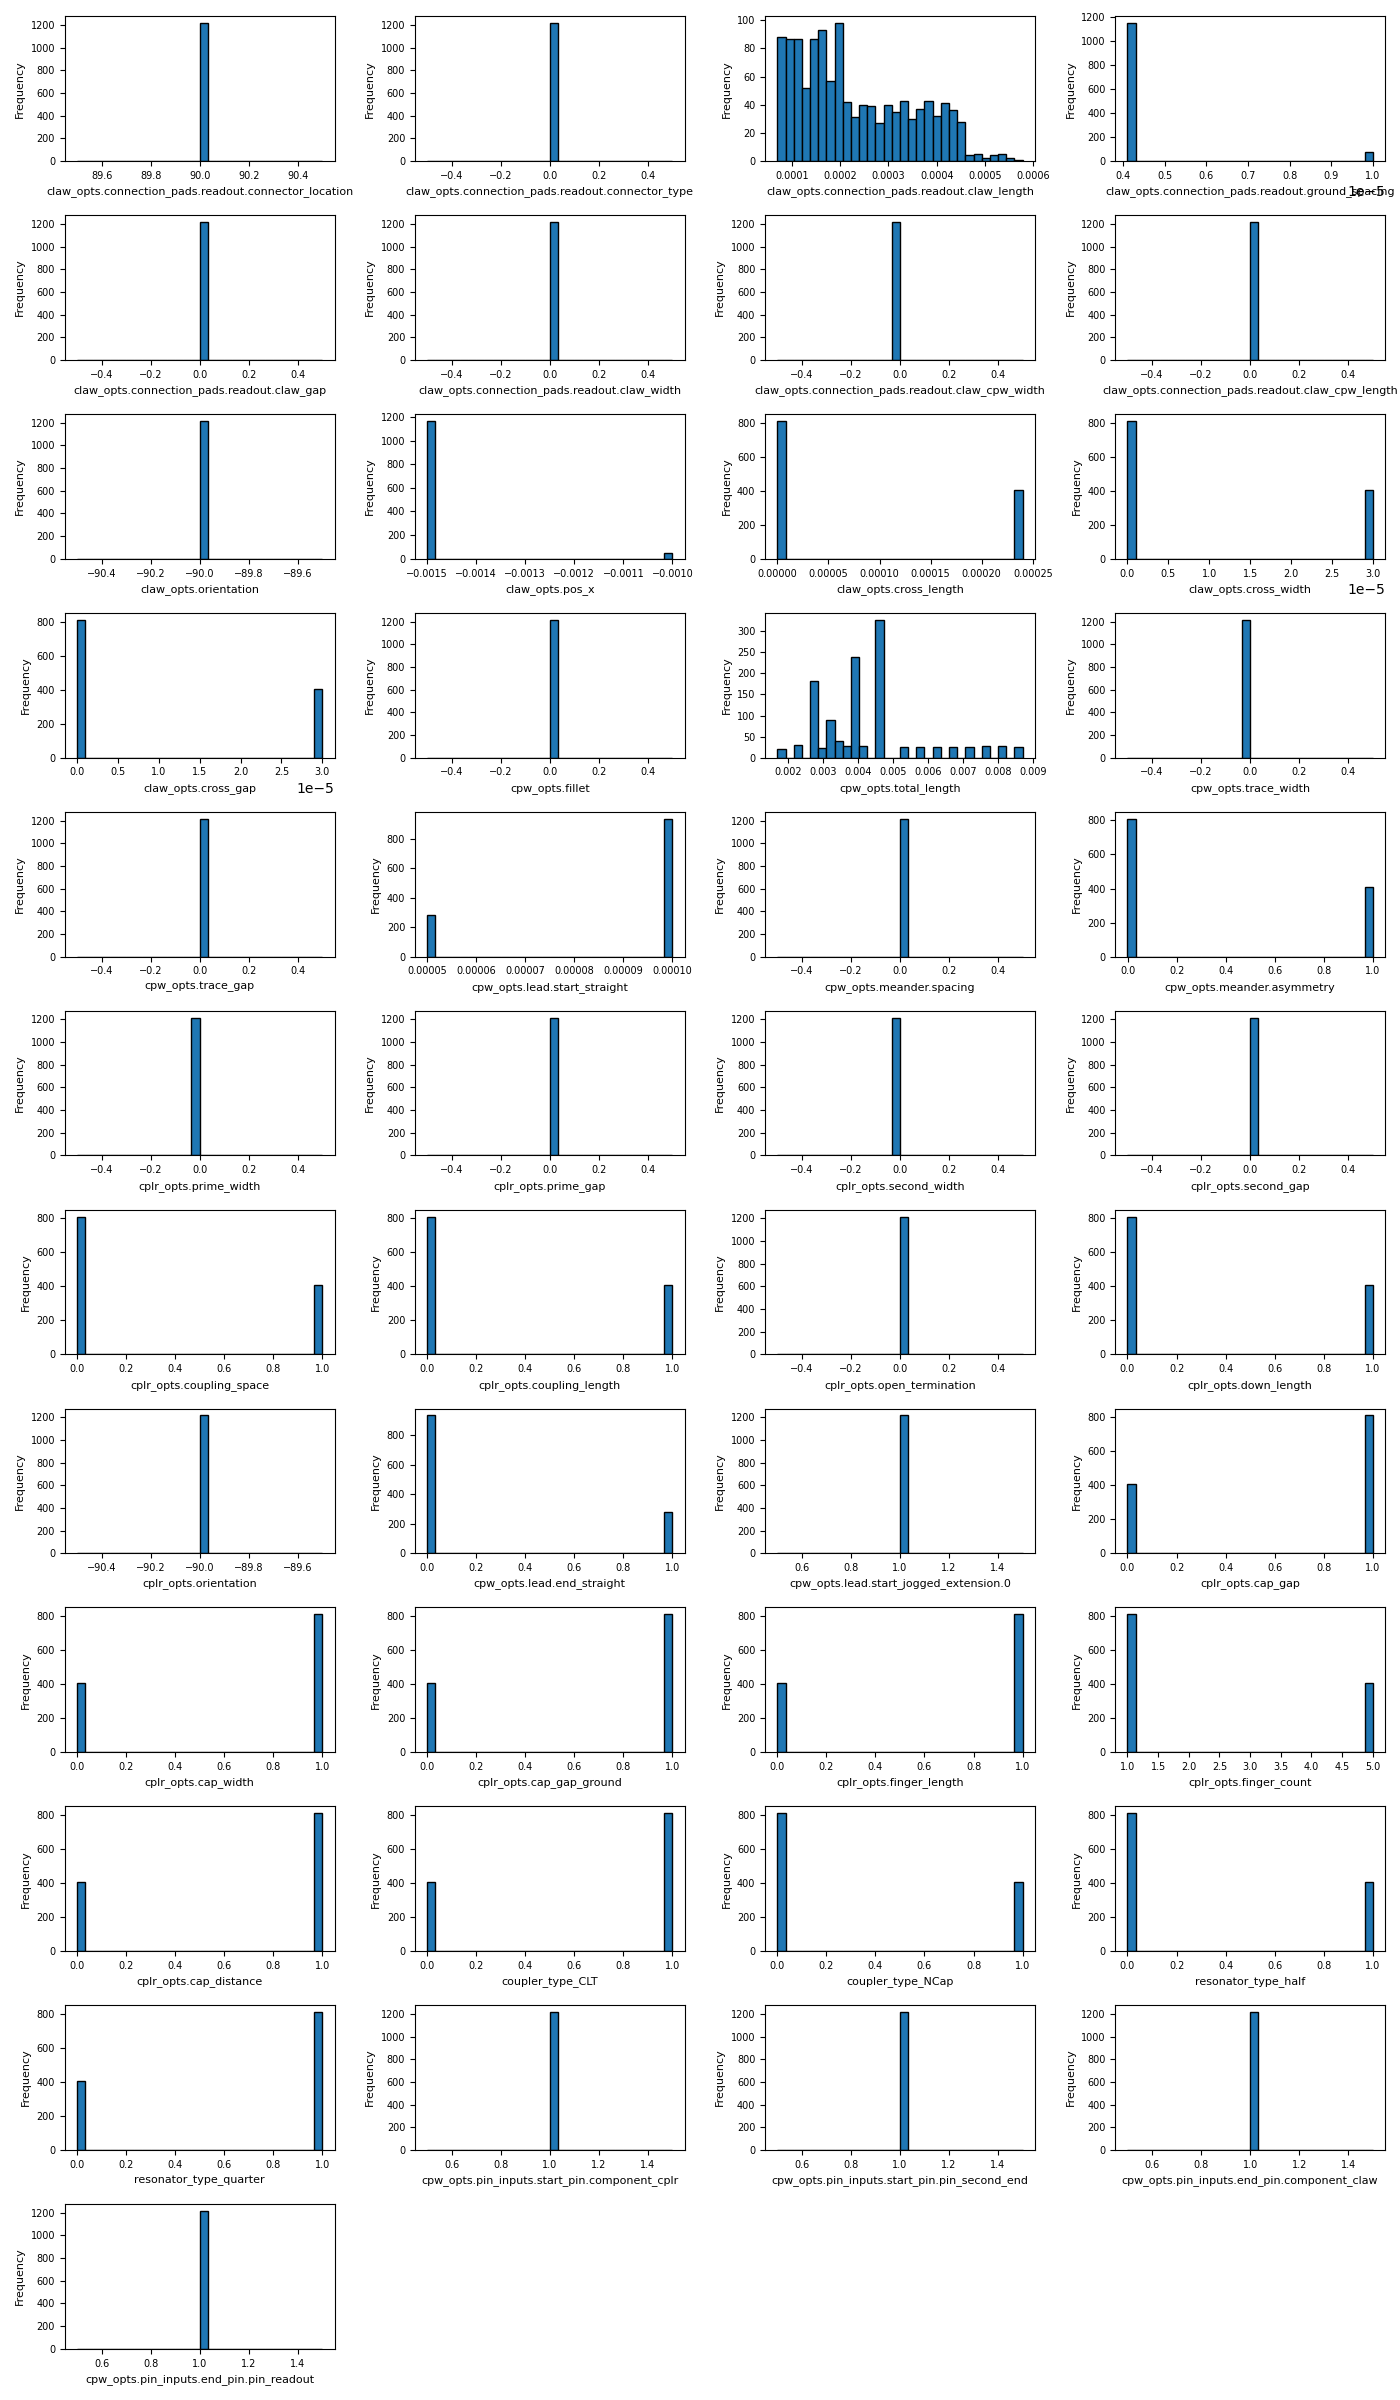

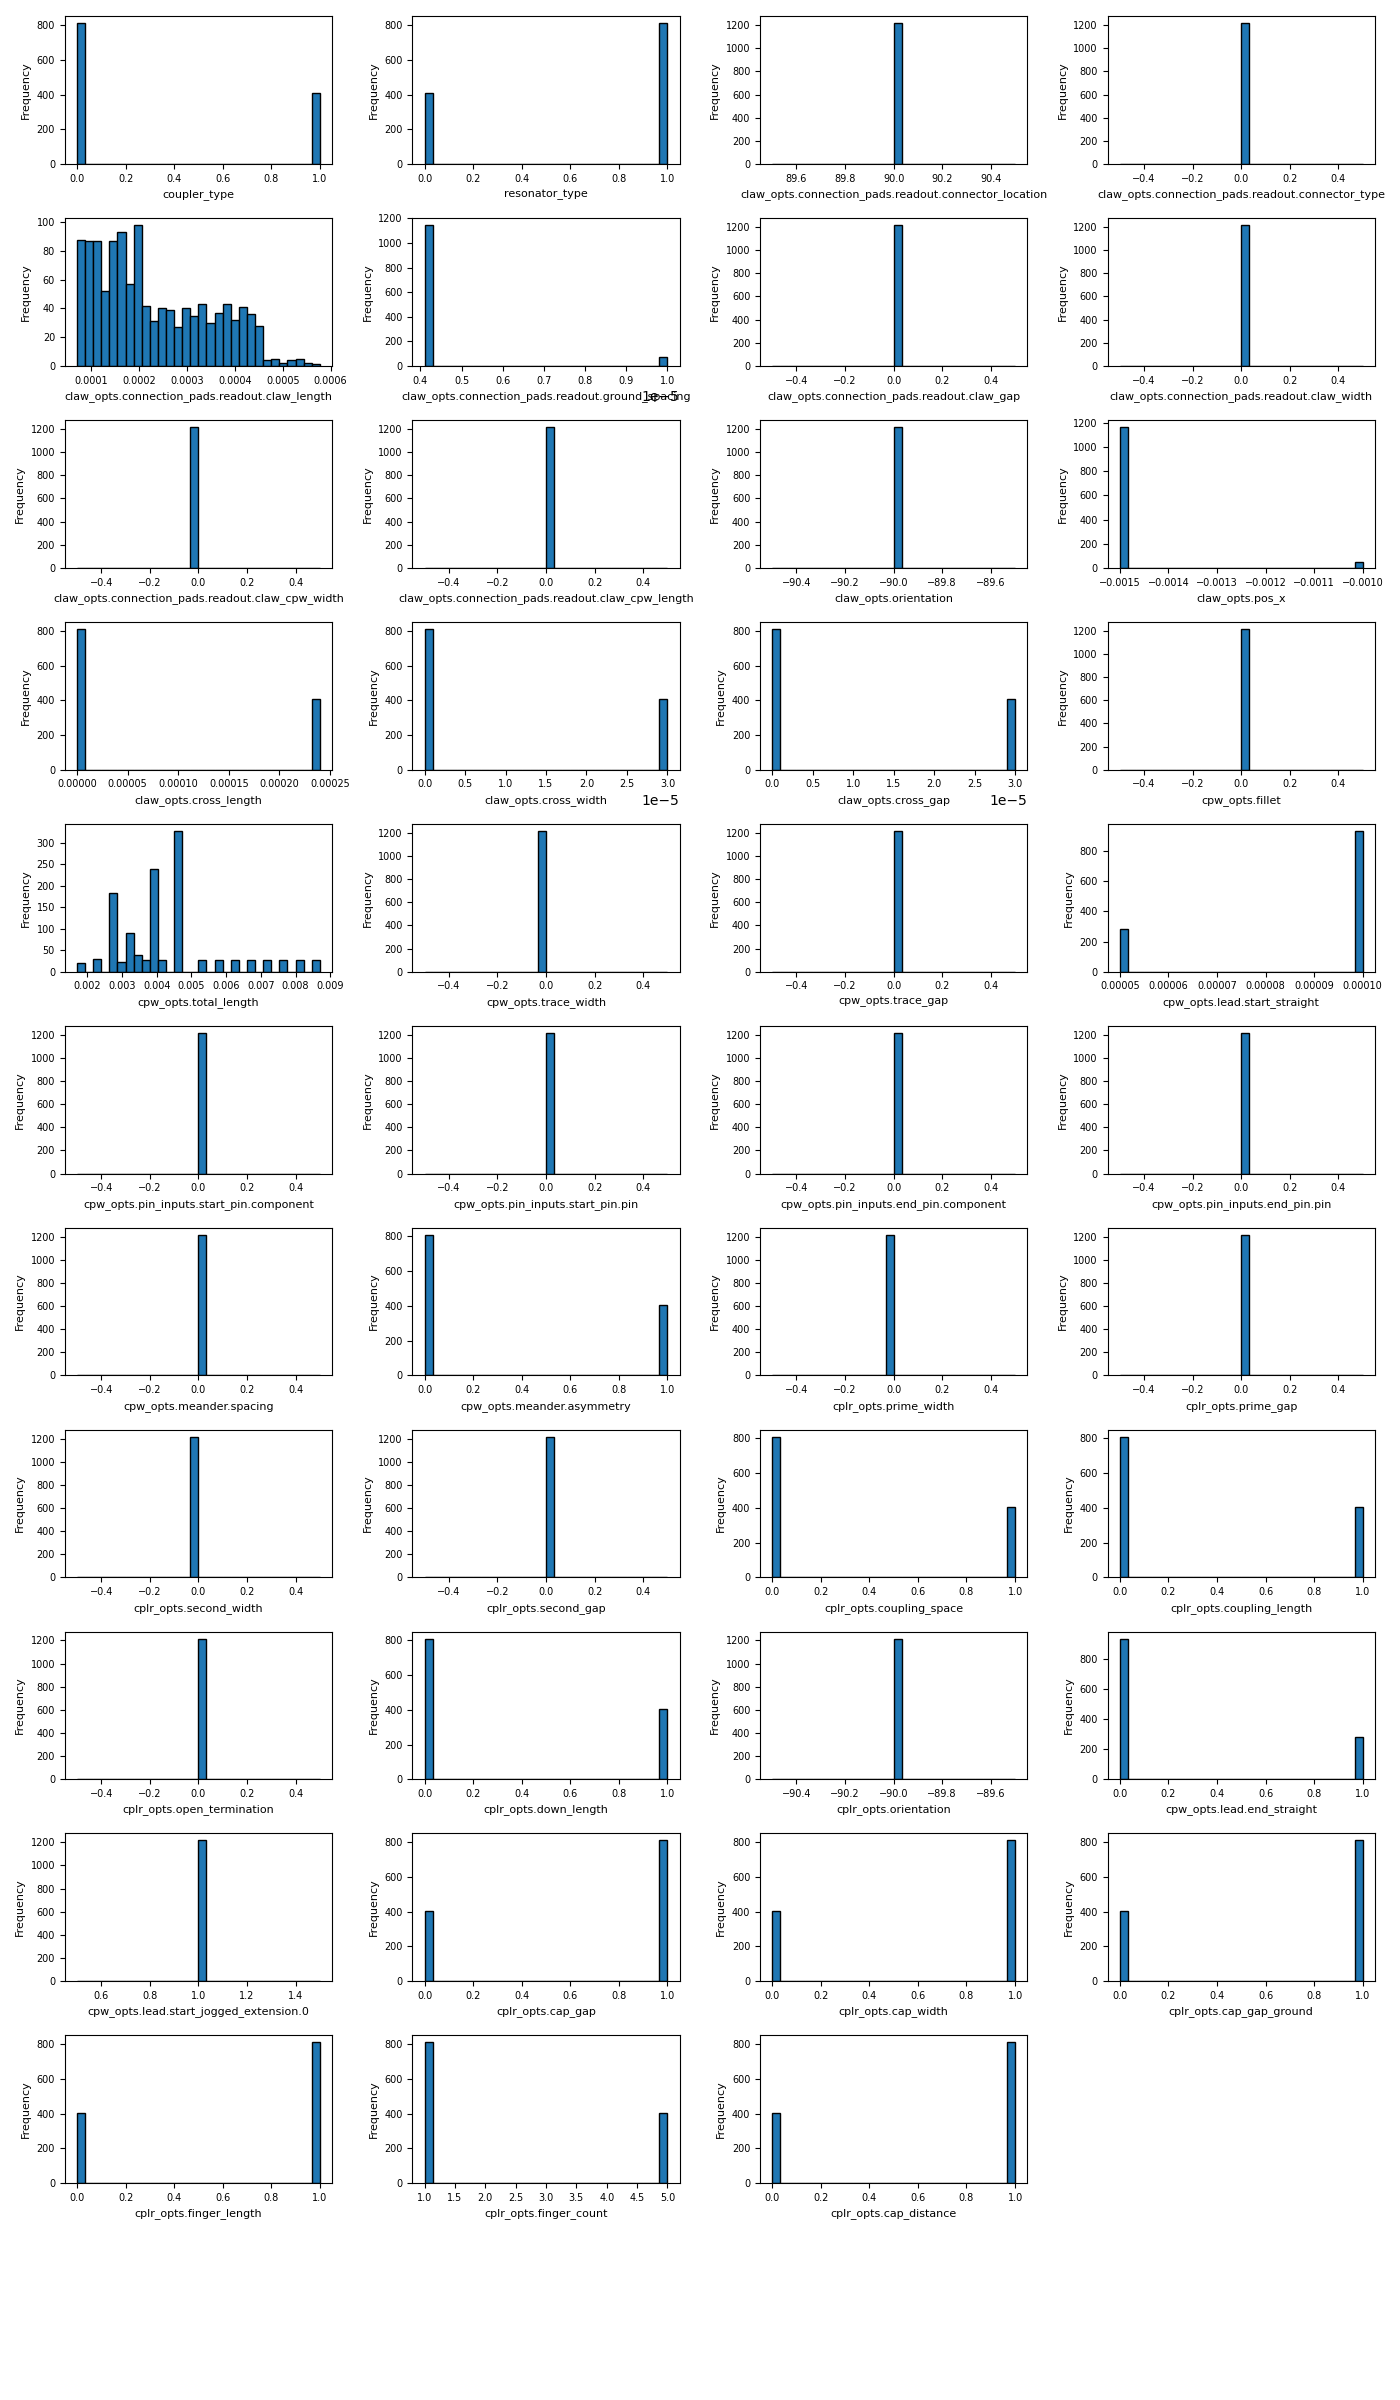

In [42]:
i=0
for y_orig in y_orig_encoding_formats:
    num_cols = len(y_orig.columns)
    num_rows = ((num_cols + 2) // 4) + 1
    
    plt.figure(figsize=(14, 2 * num_rows)) #Reduced figure size
    
    for i, col in enumerate(y_orig.columns):
        try:
            plt.subplot(num_rows, 4, i + 1)
            plt.hist(y_orig[col], bins=30, edgecolor='black')
            plt.xlabel(col.split('design_options.')[-1], fontsize=8) 
            plt.ylabel('Frequency', fontsize=8) 
            plt.tick_params(axis='both', which='major', labelsize=7) 
    
        except TypeError:
            print(f"Warning: Column '{col}' is not numeric and cannot be plotted.")
    
    plt.tight_layout()
    plt.show()
    i+=1

## Split

In [43]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
print('Tensorflow ver.', tf.__version__)

2024-11-27 16:43:56.121674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 16:43:56.121762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 16:43:56.121782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 16:43:56.129274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow ver. 2.14.0


Dataset split is 80%-20% training-validation and test sets. We use a constant state (seed) for reproducible splits across multiple runs.

In [44]:
# Unscaled data split
if 'One Hot' in ENCODING_TYPE:
    X_train, X_val_test, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val, X_test, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train, X_val_test, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val, X_test, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )
elif 'Try Both' in ENCODING_TYPE:
    X_train_one_hot_encoding, X_val_test_one_hot_encoding, y_train_one_hot_encoding, y_val_test_one_hot_encoding = train_test_split(
        X, y_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_one_hot_encoding, X_test_one_hot_encoding, y_val_one_hot_encoding, y_test_one_hot_encoding = train_test_split(
        X_val_test_one_hot_encoding, y_val_test_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    )
    X_train_linear_encoding, X_val_test_linear_encoding, y_train_linear_encoding, y_val_test_linear_encoding = train_test_split(
        X, y_encoding_formats[1], test_size=0.3, random_state=42, shuffle=True
    )
    X_val_linear_encoding, X_test_linear_encoding, y_val_linear_encoding, y_test_linear_encoding = train_test_split(
        X_val_test_linear_encoding, y_val_test_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    )

# Scaled data split
if 'One Hot' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

elif 'Linear' in ENCODING_TYPE:
    X_train_scaled, X_val_test_scaled, y_train_linear_hot_encoding, y_val_test_linear_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled, X_test_scaled, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test
elif 'Try Both' in ENCODING_TYPE:
    X_train_scaled_one_hot_encoding, X_val_test_scaled_one_hot_encoding, y_train_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_one_hot_encoding, X_test_scaled_one_hot_encoding, y_val_scaled_one_hot_encoding, y_test_scaled_one_hot_encoding = train_test_split(
        X_val_test_scaled_one_hot_encoding, y_val_test_scaled_one_hot_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test

    X_train_scaled_linear_encoding, X_val_test_scaled_linear_encoding, y_train_scaled_linear_encoding, y_val_test_scaled_linear_encoding = train_test_split(
        X_scaled, y_scaled_encoding_formats[0], test_size=0.3, random_state=42, shuffle=True
    ) # 70% train, 30% val/test
    X_val_scaled_linear_encoding, X_test_scaled_linear_encoding, y_val_scaled_linear_encoding, y_test_scaled_linear_encoding = train_test_split(
        X_val_test_scaled_linear_encoding, y_val_test_scaled_linear_encoding, test_size=0.5, random_state=42, shuffle=True
    ) # Split the 30% into 15% val, 15% test


In [45]:
#unscaled
if 'One Hot' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_one_hot_encoding.shape[0] + y_test_one_hot_encoding.shape[0] + y_val_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_one_hot_encoding.shape, (y_train_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_one_hot_encoding.shape, (y_val_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_one_hot_encoding.shape, (y_test_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_linear_encoding.shape[0] + y_test_linear_encoding.shape[0] + y_val_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_linear_encoding.shape, (y_train_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_linear_encoding.shape, (y_val_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_linear_encoding.shape, (y_test_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (851, 45), 69.98%
Validation one-hot encoding set shape: (182, 45), 14.97%
Test set shape:                 (183, 45), 15.05%
---------------------------------------
---------------------------------------
Train linear encoding set shape: (851, 43), 69.98%
Validation linear encoding set shape: (182, 43), 14.97%
Test set shape:                 (183, 43), 15.05%
---------------------------------------


In [46]:
#scaled
if 'One Hot' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Linear' in ENCODING_TYPE:
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
elif 'Try Both' in ENCODING_TYPE:
    total = y_train_scaled_one_hot_encoding.shape[0] + y_test_scaled_one_hot_encoding.shape[0] + y_val_scaled_one_hot_encoding.shape[0]
    print('---------------------------------------')
    print('Train one-hot encoding set shape: {}, {:.2f}%'.format(y_train_scaled_one_hot_encoding.shape, (y_train_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Validation one-hot encoding set shape: {}, {:.2f}%'.format(y_val_scaled_one_hot_encoding.shape, (y_val_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_one_hot_encoding.shape, (y_test_scaled_one_hot_encoding.shape[0]*100.)/total))
    print('---------------------------------------')
    
    total = y_train_scaled_linear_encoding.shape[0] + y_test_scaled_linear_encoding.shape[0] + y_val_scaled_linear_encoding.shape[0]
    print('---------------------------------------')
    print('Train linear encoding set shape: {}, {:.2f}%'.format(y_train_scaled_linear_encoding.shape, (y_train_scaled_linear_encoding.shape[0]*100.)/total))
    print('Validation linear encoding set shape: {}, {:.2f}%'.format(y_val_scaled_linear_encoding.shape, (y_val_scaled_linear_encoding.shape[0]*100.)/total))
    print('Test set shape:                 {}, {:.2f}%'.format(y_test_scaled_linear_encoding.shape, (y_test_scaled_linear_encoding.shape[0]*100.)/total))
    print('---------------------------------------')

---------------------------------------
Train one-hot encoding set shape: (851, 45), 69.98%
Validation one-hot encoding set shape: (182, 45), 14.97%
Test set shape:                 (183, 45), 15.05%
---------------------------------------
---------------------------------------
Train linear encoding set shape: (851, 45), 69.98%
Validation linear encoding set shape: (182, 45), 14.97%
Test set shape:                 (183, 45), 15.05%
---------------------------------------


In [47]:
if 'Try Both' not in ENCODING_TYPE:
    display(X_train_scaled) #can check this in next script as well after loading to make sure it matches
    display(X_val_scaled)
else:
    display(X_train_scaled_one_hot_encoding) 
    display(X_val_scaled_one_hot_encoding)
    
    display(X_train_scaled_linear_encoding) 
    display(X_val_scaled_linear_encoding)

cavity_frequency     kappa
630           0.335150  0.000787
215           0.018092  0.152657
1052          0.010328  0.147638
27            0.024358  0.159239
1172          0.121391  0.163866
...                ...       ...
1044          0.016079  0.155945
1095          0.036666  0.206972
1130          0.057548  0.256099
860           0.577813  0.001341
1126          0.061687  0.267421

[851 rows x 2 columns]

cavity_frequency     kappa
666           0.108288  0.000269
876           0.390310  0.000913
344           0.198377  0.069497
857           0.075206  0.000193
796           0.131031  0.000321
...                ...       ...
1202          0.130166  0.051869
628           0.479914  0.001118
561           0.347187  0.000814
1152          0.010721  0.208710
952           0.028968  0.190151

[182 rows x 2 columns]

cavity_frequency     kappa
630           0.335150  0.000787
215           0.018092  0.152657
1052          0.010328  0.147638
27            0.024358  0.159239
1172          0.121391  0.163866
...                ...       ...
1044          0.016079  0.155945
1095          0.036666  0.206972
1130          0.057548  0.256099
860           0.577813  0.001341
1126          0.061687  0.267421

[851 rows x 2 columns]

cavity_frequency     kappa
666           0.108288  0.000269
876           0.390310  0.000913
344           0.198377  0.069497
857           0.075206  0.000193
796           0.131031  0.000321
...                ...       ...
1202          0.130166  0.051869
628           0.479914  0.001118
561           0.347187  0.000814
1152          0.010721  0.208710
952           0.028968  0.190151

[182 rows x 2 columns]

### Save

Save the split data set for future reference

In [48]:
!rm -f $DATA_DIR/npy/*npy

In [50]:
#unscaled
if 'One Hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test.npy'.format(DATA_DIR), X_test)
    
    np.save('{}/npy/y_train.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test.npy'.format(DATA_DIR), y_test_one_hot_encoding)
elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train.npy'.format(DATA_DIR), X_train)
    np.save('{}/npy/x_val.npy'.format(DATA_DIR), X_val)
    np.save('{}/npy/x_test.npy'.format(DATA_DIR), X_test)
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding.npy'.format(DATA_DIR), X_train_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding.npy'.format(DATA_DIR), X_val_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding.npy'.format(DATA_DIR), X_test_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding.npy'.format(DATA_DIR), X_train_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding.npy'.format(DATA_DIR), X_val_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding.npy'.format(DATA_DIR), X_test_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding.npy'.format(DATA_DIR), y_train_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding.npy'.format(DATA_DIR), y_val_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding.npy'.format(DATA_DIR), y_test_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding.npy'.format(DATA_DIR), y_train_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding.npy'.format(DATA_DIR), y_val_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding.npy'.format(DATA_DIR), y_test_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [51]:
#scaled
if 'One Hot' in ENCODING_TYPE:
    np.save('{}/npy/x_train_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)

elif 'Linear' in ENCODING_TYPE:
    np.save('{}/npy/x_train_augmented.npy'.format(DATA_DIR), X_train_scaled)
    np.save('{}/npy/x_val_augmented.npy'.format(DATA_DIR), X_val_scaled)
    np.save('{}/npy/x_test_augmented.npy'.format(DATA_DIR), X_test_scaled)
    
    np.save('{}/npy/y_train_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding) 
    np.save('{}/npy/y_val_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)

elif 'Try Both' in ENCODING_TYPE:
    np.save('{}/npy/x_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_one_hot_encoding)
    np.save('{}/npy/x_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_one_hot_encoding)
    np.save('{}/npy/x_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/x_train_linear_encoding_augmented.npy'.format(DATA_DIR), X_train_scaled_linear_encoding)
    np.save('{}/npy/x_val_linear_encoding_augmented.npy'.format(DATA_DIR), X_val_scaled_linear_encoding)
    np.save('{}/npy/x_test_linear_encoding_augmented.npy'.format(DATA_DIR), X_test_scaled_linear_encoding)
    
    np.save('{}/npy/y_train_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_one_hot_encoding)
    np.save('{}/npy/y_val_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_one_hot_encoding)
    np.save('{}/npy/y_test_one_hot_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_one_hot_encoding)
    
    np.save('{}/npy/y_train_linear_encoding_augmented.npy'.format(DATA_DIR), y_train_scaled_linear_encoding)
    np.save('{}/npy/y_val_linear_encoding_augmented.npy'.format(DATA_DIR), y_val_scaled_linear_encoding)
    np.save('{}/npy/y_test_linear_encoding_augmented.npy'.format(DATA_DIR), y_test_scaled_linear_encoding)
    
print('Data saved in: {}/npy'.format(DATA_DIR))

Data saved in: data/npy


In [52]:
!ls $DATA_DIR/npy/*npy

data/npy/x_test_linear_encoding_augmented.npy
data/npy/x_test_linear_encoding.npy
data/npy/x_test_one_hot_encoding_augmented.npy
data/npy/x_test_one_hot_encoding.npy
data/npy/x_train_linear_encoding_augmented.npy
data/npy/x_train_linear_encoding.npy
data/npy/x_train_one_hot_encoding_augmented.npy
data/npy/x_train_one_hot_encoding.npy
data/npy/x_val_linear_encoding_augmented.npy
data/npy/x_val_linear_encoding.npy
data/npy/x_val_one_hot_encoding_augmented.npy
data/npy/x_val_one_hot_encoding.npy
data/npy/y_test_linear_encoding_augmented.npy
data/npy/y_test_linear_encoding.npy
data/npy/y_test_one_hot_encoding_augmented.npy
data/npy/y_test_one_hot_encoding.npy
data/npy/y_train_linear_encoding_augmented.npy
data/npy/y_train_linear_encoding.npy
data/npy/y_train_one_hot_encoding_augmented.npy
data/npy/y_train_one_hot_encoding.npy
data/npy/y_val_linear_encoding_augmented.npy
data/npy/y_val_linear_encoding.npy
data/npy/y_val_one_hot_encoding_augmented.npy
data/npy/y_val_one_hot_encoding.npy
